<a href="https://colab.research.google.com/github/SeungjaeHwang354/Exchange-rate-medeling-by-OU-Process/blob/main/%EC%9E%A5%ED%94%8C_%EC%BD%94%EB%93%9C_%EC%B5%9C%EC%A2%85_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 📌 1.. 리스크 프리미엄 도입한 수정 모델

전통적인 이자율 평형이론(UIP)은 다음과 같이 표현됩니다:

$$
\mathbb{E}_t\left[ \log\left(\frac{S_{t+1}}{S_t}\right) \right] = i_t^{US} - i_t^{KR}
$$

하지만 현실에서는 이 등식이 자주 성립하지 않으며,  
이를 보완하기 위해 **위험 프리미엄 $K_t$**를 도입합니다:

$$
\log\left(\frac{S_{t+1}}{S_t}\right) = \left(i_t^{US} - i_t^{KR} + K_t \right) \cdot dt + \varepsilon_t
$$

---

### 📌 리스크 프리미엄 정의

본 분석에서는 $K_t$을 다음과 같이 정의합니다:

$$
K_t = \log\left( \frac{S_{t+n}}{S_t} \right) - (i_t^{US} - i_t^{KR})
$$

- $S_t$: 현재 환율, $S_{t+252}$: n기간후 환율
- $i^{US}, i^{KR}$: 미국, 한국 무위험 금리 (연율)

이 정의에 따르면 $K_t$는 **1년 동안의 실제 환율 상승률**과  
**금리차가 예측한 환율 상승률** 간의 차이로 해석되며,  
**환율에 반영되지 않은 초과 수익률 (위험 프리미엄)**을 의미합니다.
데이터에 따르면 기간이 짧아질수록 강한 0을 중심으로 강한 진동을 보임

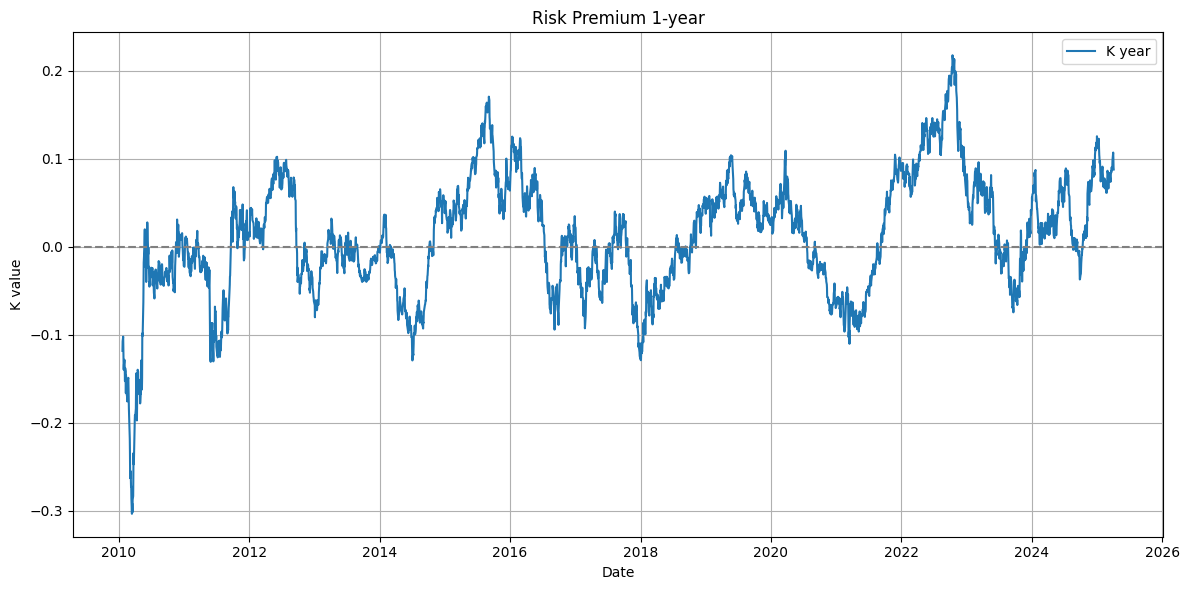

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
fx = pd.read_csv('fx.csv')[['날짜', '종가']]
us = pd.read_csv('us_bond.csv')[['날짜', '종가']]
kr = pd.read_csv('kr_bond.csv')[['날짜', '종가']]

fx['Date'] = pd.to_datetime(fx['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
us['Date'] = pd.to_datetime(us['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
kr['Date'] = pd.to_datetime(kr['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
fx['Close'] = fx['종가'].str.replace(",", "").astype(float)
us['Close'] = us['종가'].astype(float)
kr['Close'] = kr['종가'].astype(float)

fx = fx.rename(columns={"Close": "spot_rate"})
us = us.rename(columns={"Close": "us_rate"})
kr = kr.rename(columns={"Close": "kr_rate"})

df = fx.merge(kr, on='Date').merge(us, on='Date')
df = df.dropna().sort_values('Date').reset_index(drop=True)

# 2. 직접 계산한 K 값 (1년 = 252일 기준)
k_direct = []
date_list = []

for i in range(len(df) - 252):
    s_now = df['spot_rate'].iloc[i]
    s_future = df['spot_rate'].iloc[i + 252]
    r_diff_now = (df['us_rate'].iloc[i] - df['kr_rate'].iloc[i]) / 100  # 연간 금리차
    K_approx = np.log(s_future / s_now) - r_diff_now
    k_direct.append(K_approx)
    date_list.append(df['Date'].iloc[i + 252])

k_df = pd.DataFrame({
    'Date': date_list,
    'K_direct': k_direct
})

# 3. 시각화
plt.figure(figsize=(12, 6))
plt.plot(k_df['Date'], k_df['K_direct'], label='K year')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Risk Premium 1-year")
plt.xlabel("Date")
plt.ylabel("K value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

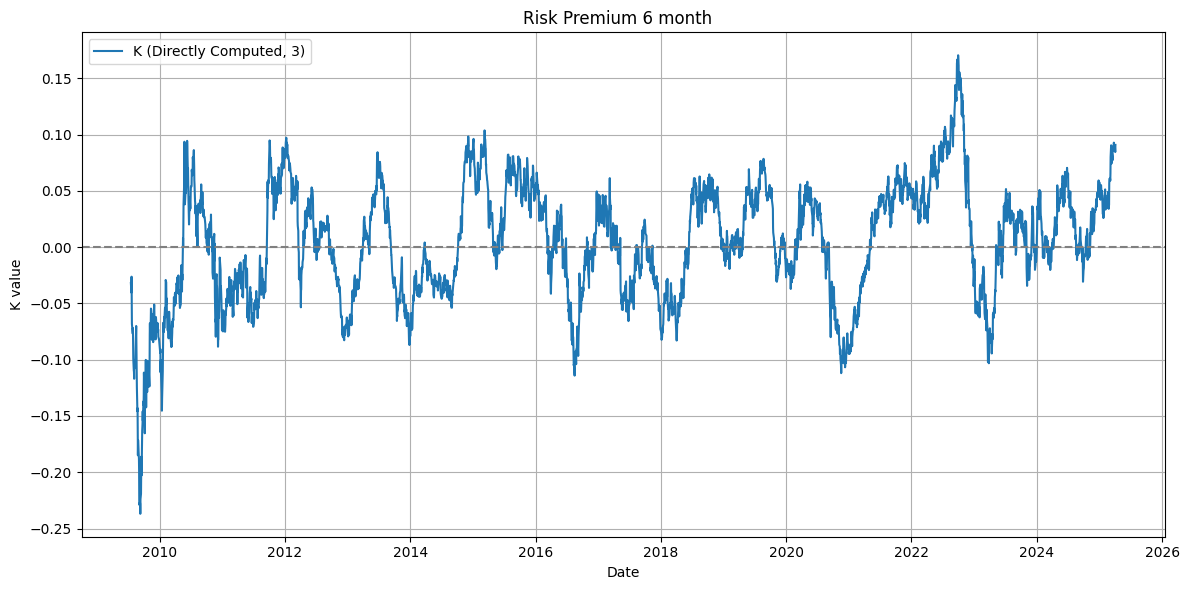

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 (생략하지 않고 전체 유지)
fx = pd.read_csv('fx.csv')[['날짜', '종가']]
us = pd.read_csv('us_bond.csv')[['날짜', '종가']]
kr = pd.read_csv('kr_bond.csv')[['날짜', '종가']]

fx['Date'] = pd.to_datetime(fx['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
us['Date'] = pd.to_datetime(us['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
kr['Date'] = pd.to_datetime(kr['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
fx['Close'] = fx['종가'].str.replace(",", "").astype(float)
us['Close'] = us['종가'].astype(float)
kr['Close'] = kr['종가'].astype(float)

fx = fx.rename(columns={"Close": "spot_rate"})
us = us.rename(columns={"Close": "us_rate"})
kr = kr.rename(columns={"Close": "kr_rate"})

df = fx.merge(kr, on='Date').merge(us, on='Date')
df = df.dropna().sort_values('Date').reset_index(drop=True)

# 2. K 계산 (3개월 = 63일 기준)
horizon = 126  # 3개월 = 63 영업일
k_direct = []
date_list = []

for i in range(len(df) - horizon):
    s_now = df['spot_rate'].iloc[i]
    s_future = df['spot_rate'].iloc[i + horizon]

    # 연 금리 → 3개월 금리로 환산
    r_diff_3mo = ((df['us_rate'].iloc[i] - df['kr_rate'].iloc[i]) / 100) * (horizon / 252)

    K_approx = np.log(s_future / s_now) - r_diff_3mo
    k_direct.append(K_approx)
    date_list.append(df['Date'].iloc[i + horizon])

k_df = pd.DataFrame({
    'Date': date_list,
    'K_direct': k_direct
})

# 3. 시각화
plt.figure(figsize=(12, 6))
plt.plot(k_df['Date'], k_df['K_direct'], label='K (Directly Computed, 3)')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Risk Premium 6 month  ")
plt.xlabel("Date")
plt.ylabel("K value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

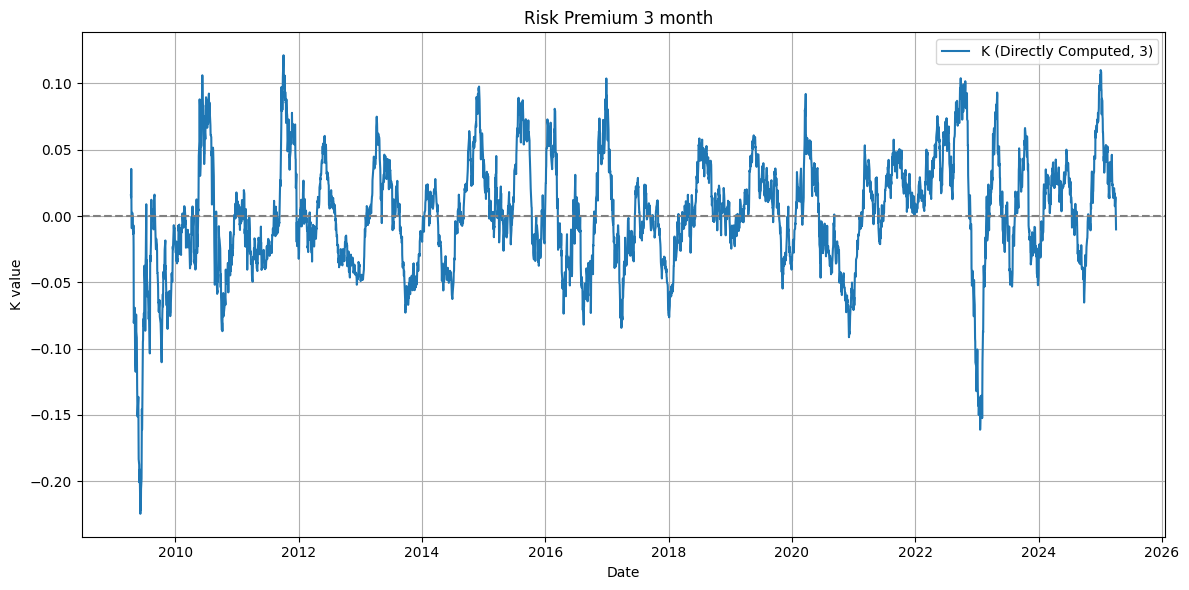

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 (생략하지 않고 전체 유지)
fx = pd.read_csv('fx.csv')[['날짜', '종가']]
us = pd.read_csv('us_bond.csv')[['날짜', '종가']]
kr = pd.read_csv('kr_bond.csv')[['날짜', '종가']]

fx['Date'] = pd.to_datetime(fx['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
us['Date'] = pd.to_datetime(us['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
kr['Date'] = pd.to_datetime(kr['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
fx['Close'] = fx['종가'].str.replace(",", "").astype(float)
us['Close'] = us['종가'].astype(float)
kr['Close'] = kr['종가'].astype(float)

fx = fx.rename(columns={"Close": "spot_rate"})
us = us.rename(columns={"Close": "us_rate"})
kr = kr.rename(columns={"Close": "kr_rate"})

df = fx.merge(kr, on='Date').merge(us, on='Date')
df = df.dropna().sort_values('Date').reset_index(drop=True)

# 2. K 계산 (3개월 = 63일 기준)
horizon = 63  # 3개월 = 63 영업일
k_direct = []
date_list = []

for i in range(len(df) - horizon):
    s_now = df['spot_rate'].iloc[i]
    s_future = df['spot_rate'].iloc[i + horizon]

    # 연 금리 → 3개월 금리로 환산
    r_diff_3mo = ((df['us_rate'].iloc[i] - df['kr_rate'].iloc[i]) / 100) * (horizon / 252)

    K_approx = np.log(s_future / s_now) - r_diff_3mo
    k_direct.append(K_approx)
    date_list.append(df['Date'].iloc[i + horizon])

k_df = pd.DataFrame({
    'Date': date_list,
    'K_direct': k_direct
})

# 3. 시각화
plt.figure(figsize=(12, 6))
plt.plot(k_df['Date'], k_df['K_direct'], label='K (Directly Computed, 3)')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Risk Premium 3 month  ")
plt.xlabel("Date")
plt.ylabel("K value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

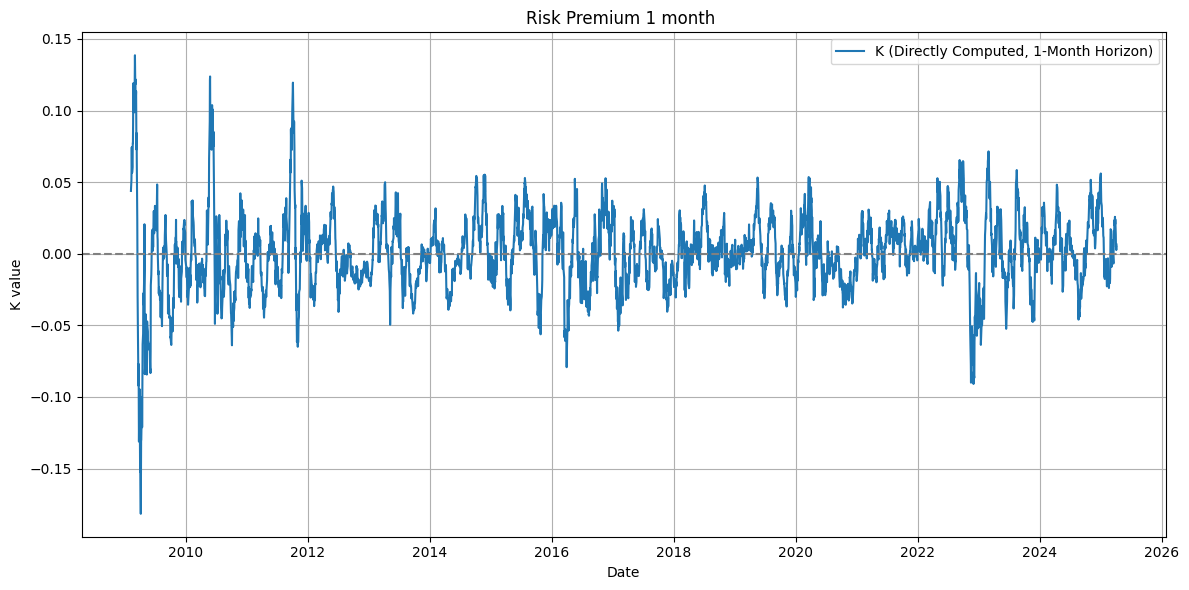

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 (생략하지 않고 전체 유지)
fx = pd.read_csv('fx.csv')[['날짜', '종가']]
us = pd.read_csv('us_bond.csv')[['날짜', '종가']]
kr = pd.read_csv('kr_bond.csv')[['날짜', '종가']]

fx['Date'] = pd.to_datetime(fx['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
us['Date'] = pd.to_datetime(us['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
kr['Date'] = pd.to_datetime(kr['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
fx['Close'] = fx['종가'].str.replace(",", "").astype(float)
us['Close'] = us['종가'].astype(float)
kr['Close'] = kr['종가'].astype(float)

fx = fx.rename(columns={"Close": "spot_rate"})
us = us.rename(columns={"Close": "us_rate"})
kr = kr.rename(columns={"Close": "kr_rate"})

df = fx.merge(kr, on='Date').merge(us, on='Date')
df = df.dropna().sort_values('Date').reset_index(drop=True)

# 2. K 계산 (1개월 = 21일 기준)
horizon = 21  # 1개월 = 21 영업일
k_direct = []
date_list = []

for i in range(len(df) - horizon):
    s_now = df['spot_rate'].iloc[i]
    s_future = df['spot_rate'].iloc[i + horizon]

    # 연 금리 → 3개월 금리로 환산
    r_diff_3mo = ((df['us_rate'].iloc[i] - df['kr_rate'].iloc[i]) / 100) * (horizon / 252)

    K_approx = np.log(s_future / s_now) - r_diff_3mo
    k_direct.append(K_approx)
    date_list.append(df['Date'].iloc[i + horizon])

k_df = pd.DataFrame({
    'Date': date_list,
    'K_direct': k_direct
})

# 3. 시각화
plt.figure(figsize=(12, 6))
plt.plot(k_df['Date'], k_df['K_direct'], label='K (Directly Computed, 1-Month Horizon)')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Risk Premium 1 month ")
plt.xlabel("Date")
plt.ylabel("K value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

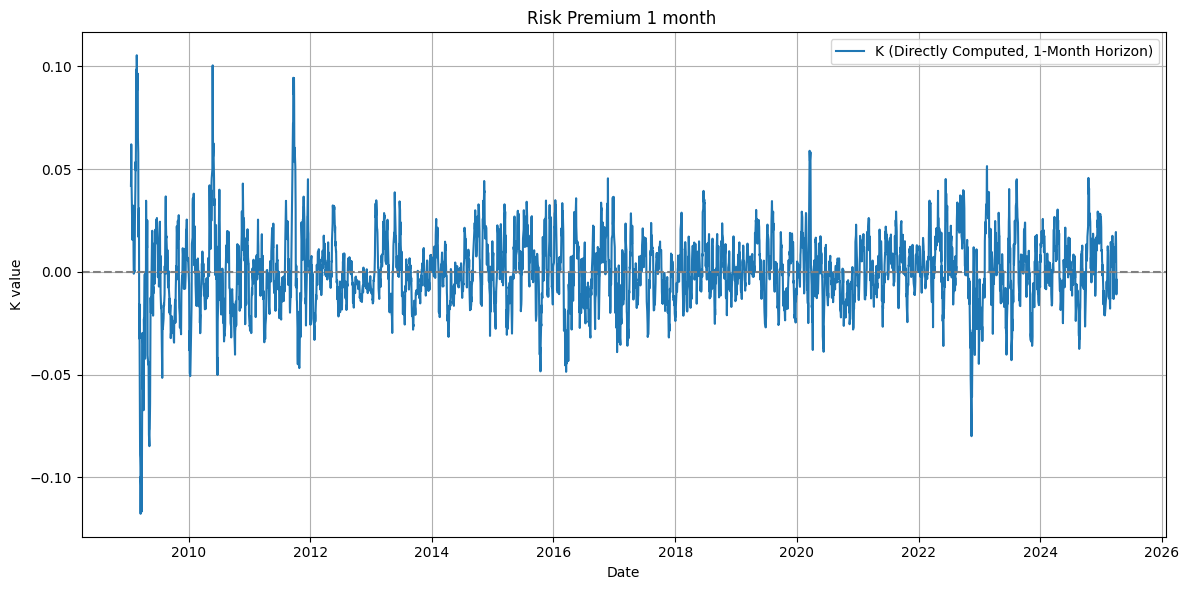

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 (생략하지 않고 전체 유지)
fx = pd.read_csv('fx.csv')[['날짜', '종가']]
us = pd.read_csv('us_bond.csv')[['날짜', '종가']]
kr = pd.read_csv('kr_bond.csv')[['날짜', '종가']]

fx['Date'] = pd.to_datetime(fx['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
us['Date'] = pd.to_datetime(us['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
kr['Date'] = pd.to_datetime(kr['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
fx['Close'] = fx['종가'].str.replace(",", "").astype(float)
us['Close'] = us['종가'].astype(float)
kr['Close'] = kr['종가'].astype(float)

fx = fx.rename(columns={"Close": "spot_rate"})
us = us.rename(columns={"Close": "us_rate"})
kr = kr.rename(columns={"Close": "kr_rate"})

df = fx.merge(kr, on='Date').merge(us, on='Date')
df = df.dropna().sort_values('Date').reset_index(drop=True)

# 2. K 계산
horizon = 10  # 2week
k_direct = []
date_list = []

for i in range(len(df) - horizon):
    s_now = df['spot_rate'].iloc[i]
    s_future = df['spot_rate'].iloc[i + horizon]

    # 연 금리 → 3개월 금리로 환산
    r_diff_3mo = ((df['us_rate'].iloc[i] - df['kr_rate'].iloc[i]) / 100) * (horizon / 252)

    K_approx = np.log(s_future / s_now) - r_diff_3mo
    k_direct.append(K_approx)
    date_list.append(df['Date'].iloc[i + horizon])

k_df = pd.DataFrame({
    'Date': date_list,
    'K_direct': k_direct
})

# 3. 시각화
plt.figure(figsize=(12, 6))
plt.plot(k_df['Date'], k_df['K_direct'], label='K (Directly Computed, 1-Month Horizon)')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Risk Premium 1 month ")
plt.xlabel("Date")
plt.ylabel("K value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔁 Why OU Process for Risk Premium?  
리스크 프리미엄 $ K_t $은 다음과 같은 성질을 갖습니다:

- 📉 **단기적으로는 급격하게 움직이고**
- 📈 **장기적으로는 한 방향으로 쏠리기보다는, 평균 근처에서 출렁임을 반복**합니다

이러한 성질은 **Ornstein–Uhlenbeck (OU) 프로세스**로 자연스럽게 모델링할 수 있습니다:



$dK_t = \theta(\mu - K_t)\,dt + \sigma\,dZ_t$



- OU는 단순한 평균회귀를 넘어서  
  **평균을 중심으로 계속해서 진동하며 움직이는 확률 과정**입니다.
- $ \theta $가 작을수록 회귀는 느려지고,
$\sigma $가 클수록 진동 폭이 커집니다.

---

### 🔍 진짜 포인트: "수렴"이 아니라 "진동"

OU의 해석적 해는 다음과 같습니다:



$K_t = K_0 e^{-\theta t} + \mu(1 - e^{-\theta t}) + \sigma \int_0^t e^{-\theta(t-s)} dZ_s$


- 앞의 두 항은 **결정론적 평균 수렴 효과**를 설명하고,  
- 마지막 항인  
  $
  \sigma \int_0^t e^{-\theta(t-s)} dZ_s
  $  
  은 **평균 주위에서 지속적으로 진동하는 확률적 요인**을 설명합니다.

---

### ✅ 결론

> 리스크 프리미엄은 현실적으로 **단순 수렴**하지 않고,  
> **중심 수준을 계속해서 오르내리는 "진동성(mean-reverting oscillation)"**을 보입니다.  
>  
> OU 프로세스는 이러한 **"진동하는 복원력 있는 동태"**를 수학적으로 설명할 수 있는 가장 적절한 도구입니다.


### 📌 이자율 평형이론과 OU 프로세스를 이용한 환율 SDE 도출

이자율 평형이론(Uncovered Interest Parity, UIP)은 두 국가 간 무위험 이자율의 차이가  
기대 환율 수익률을 결정한다는 고전적인 가설이다:

$$
\mathbb{E}_t\left[ \log\left( \frac{S_{t+1}}{S_t} \right) \right] = i_t^{US} - i_t^{KR}
$$

하지만 현실에서는 해당 등식이 자주 성립하지 않으며,  
그 괴리를 설명하기 위해 본 분석에서는 **리스크 프리미엄 \( K_t \)**을 도입한다:

$$
\log\left( \frac{S_{t+1}}{S_t} \right) = \left(i_t^{US} - i_t^{KR} + K_t\right) \cdot dt + \varepsilon_t
$$

위 식을 연속 시간의 확률 미분방정식(SDE) 형태로 일반화하면 다음과 같다:

$$
\frac{dS_t}{S_t} = \left(i_t^{US} - i_t^{KR} + K_t\right) dt + \sigma_S dW_t
$$

여기서, 리스크 프리미엄 \( K_t \)는 고정된 상수가 아니라 **시간에 따라 변화하는 확률 과정**이며,  
그 동태를 **Ornstein–Uhlenbeck(OU) 프로세스**로 모델링한다:

$$
dK_t = \theta(\mu - K_t) dt + \sigma_K dZ_t
$$

이로써, 본 모델은 다음과 같은 **2차원 연립 확률 미분방정식 시스템**이 된다:

\[
\begin{cases}
dK_t = \theta(\mu - K_t) dt + \sigma_K dZ_t \\
\displaystyle \frac{dS_t}{S_t} = (r^{int}_t + K_t) dt + \sigma_S dW_t
\end{cases}
\]

여기서
$$
 r^{int}_t = i_t^{US} - i_t^{KR}  이며,  
 W_t ,  Z_t
$$는 독립적인 표준 브라운 운동이라 가정한다.

이 모델은 금리차가 환율의 기본적인 드리프트를 제공하되,  
단기적으로는 리스크 프리미엄의 존재로 인해 괴리가 발생하며,  
해당 프리미엄은 시간이 지나면서 평균으로 회귀하게 되는 구조를 반영한다.


### 🔁 Step 1: 리스크 프리미엄 \( K_t \)를 OU 프로세스로 가정

OU(Ornstein–Uhlenbeck) 프로세스는 평균 회귀 성질을 갖는 확률 과정으로 다음과 같이 정의됩니다:

$$
dK_t = \theta(\mu - K_t)dt + \sigma_K dZ_t
$$

이 식의 해석적 해는 다음과 같습니다:

$$
K_t = K_0 e^{-\theta t} + \mu (1 - e^{-\theta t}) + \sigma_K \int_0^t e^{-\theta(t - s)} dZ_s
$$

---

### 🔁 Step 2: \( K_t \)를 환율 SDE에 대입하고 적분

환율의 로그 수익률로 식을 바꾸고 적분하면:

$$
\log S_t = \log S_0 + \int_0^t \left( r^{int} + K_s \right) ds + \int_0^t \sigma_S dW_s
$$

이때,
$$\int_0^t \sigma_S dW_s = \sigma_S W_t $$ (정규분포를 따르는 확률항)

---

### 🔁 Step 3: $$ \int_0^t K_s \, ds $$ 항을 항목별로 해석적 근사

OU 해의 첫 두 항은 결정론적이므로 기댓값 기준으로 적분 가능:

1. 첫 항:

$$
\int_0^t K_0 e^{-\theta s} ds = \frac{K_0}{\theta}(1 - e^{-\theta t})
$$

2. 두 번째 항:

$$
\int_0^t \mu (1 - e^{-\theta s}) ds = \mu \left[ t - \frac{1 - e^{-\theta t}}{\theta} \right]
$$

3. 마지막 항은 확률항이며 기대값이 0이므로 생략 가능 (분산은 모델링에 사용 가능)

---

### ✅ 최종 해석적 근사해

위 결과를 종합하면 환율의 로그는 다음과 같이 근사됩니다:

$$
\log S_t \approx \log S_0 + r^{int} \cdot t
+ \left[
\frac{K_0}{\theta}(1 - e^{-\theta t}) + \mu\left(t - \frac{1 - e^{-\theta t}}{\theta}\right)
\right]
+ \sigma_S W_t +\sigma_K \int_0^t e^{-\theta(t - s)} dZ_s
$$

---

### 🔍 해석 요약
$$
  r^{int} \cdot t : 금리차에 의한 선형 상승
$$
$$
  \left[
\frac{K_0}{\theta}(1 - e^{-\theta t}) + \mu\left(t - \frac{1 - e^{-\theta t}}{\theta}\right)
\right] : 리스크 프리미엄이 진동하는 효과
$$
$
  \sigma_S W_t $$: 무작위 환율 충격 (정규분포)
$
이 근사해는 리스크 프리미엄이 단기적으로 진동하는 것을 반영합니다.

### 📘 OU + 브라운운동 기반 환율 모델의 PDF 해석

환율의 로그는 다음과 같은 확률 미분 방정식을 따릅니다:

$$
\log S_t = \log S_0 + r^{int} \cdot t +
\left[ \frac{K_0}{\theta}(1 - e^{-\theta t}) + \mu \left(t - \frac{1 - e^{-\theta t}}{\theta} \right) \right]
+ \sigma_S W_t + \sigma_K \int_0^t e^{-\theta(t - s)} dZ_s
$$

---

#### ✅ 확률항 정리

확률항은 두 개의 독립된 정규분포 항으로 구성됩니다:

- 브라운 운동 항:

$$
\sigma_S W_t \sim N(0, \sigma_S^2 t)
$$

- OU 확률항:

$$
\sigma_K \int_0^t e^{-\theta(t - s)} dZ_s \sim N\left(0, \frac{\sigma_K^2}{2\theta}(1 - e^{-2\theta t}) \right)
$$

따라서 전체 로그환율 $\log S_t$ 는 다음과 같은 정규분포를 따릅니다:

$$
\log S_t \sim N(\mu_t, \sigma_t^2)
$$

- 평균:

$$
\mu_t = \log S_0 + r^{int} \cdot t + \frac{K_0}{\theta}(1 - e^{-\theta t}) + \mu \left(t - \frac{1 - e^{-\theta t}}{\theta} \right)
$$

- 분산:

$$
\sigma_t^2 = \sigma_S^2 t + \frac{\sigma_K^2}{2\theta}(1 - e^{-2\theta t})
$$

---

#### ✅ 환율 $S_t$의 분포

$\log S_t$가 정규분포를 따르므로, $S_t$는 로그정규분포를 따릅니다:

$$
S_t \sim \text{LogNormal}(\mu_t, \sigma_t^2)
$$

확률밀도함수(PDF)는 다음과 같이 표현됩니다:

$$
f_{S_t}(s) =
\frac{1}{s \cdot \sigma_t \sqrt{2\pi}} \exp\left( -\frac{(\ln s - \mu_t)^2}{2\sigma_t^2} \right)
$$

이 식은 시점 $t$에서 환율 $S_t$가 어떤 값을 가질 확률이 높은지를 수학적으로 보여줍니다.

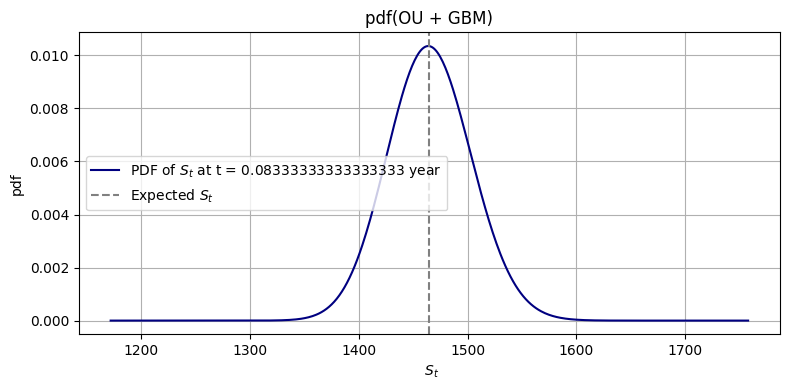

기댓값 E[log S_t]: 7.2896
분산 Var[log S_t]: 0.000692
기댓값 E[S_t] ≈ 1464.96


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# ✅ [Step 1] 변수 입력
theta = 10        # OU 평균회귀 속도
sigma_K = 0.054       # OU 확률항 노이즈
sigma_S = 0.083       # 브라운운동 노이즈
r_int = 0.015   # 금리차 (미국 - 한국)
K0 = 0.05          # 초기 리스크 프리미엄
mu_K = 0              # 장기 리스크 프리미엄 평균
S0 = 1459         # 현재 환율 (ex: 원/달러)
t = 1/12         # 예측 시점 (1년 후)

# ✅ [Step 2] 기댓값 계산
log_S0 = np.log(S0)
E_logS_t = (
    log_S0 + r_int * t +
    (K0 / theta) * (1 - np.exp(-theta * t)) +
    mu_K * (t - (1 - np.exp(-theta * t)) / theta)
)

# ✅ [Step 3] 분산 계산
Var_logS_t = sigma_S**2 * t + (sigma_K**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t))
Std_logS_t = np.sqrt(Var_logS_t)

# ✅ [Step 4] 로그정규분포 PDF 계산
s_vals = np.linspace(0.8 * np.exp(E_logS_t), 1.2 * np.exp(E_logS_t), 500)
pdf_vals = lognorm.pdf(s_vals, s=Std_logS_t, scale=np.exp(E_logS_t))

# ✅ [Step 5] 시각화
plt.figure(figsize=(8, 4))
plt.plot(s_vals, pdf_vals, label=f'PDF of $S_t$ at t = {t} year', color='navy')
plt.axvline(np.exp(E_logS_t), color='gray', linestyle='--', label='Expected $S_t$')
plt.title('pdf(OU + GBM)')
plt.xlabel(' $S_t$')
plt.ylabel('pdf')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ [출력값: 기댓값과 분산]
print(f"기댓값 E[log S_t]: {E_logS_t:.4f}")
print(f"분산 Var[log S_t]: {Var_logS_t:.6f}")
print(f"기댓값 E[S_t] ≈ {np.exp(E_logS_t):.2f}")

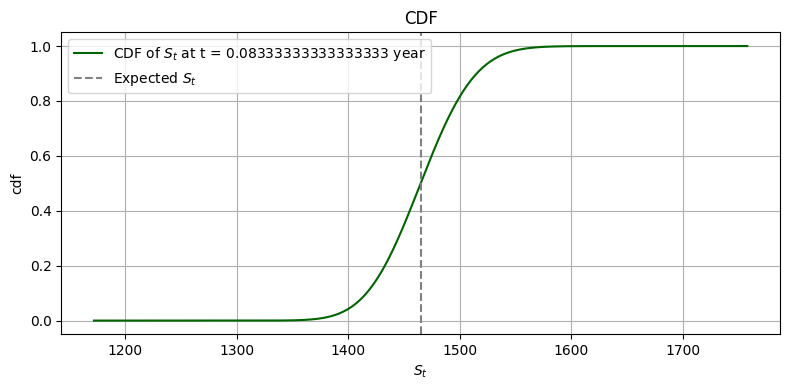

In [ ]:
# ✅ 로그정규분포 누적분포함수 (CDF) 계산 및 시각화
from scipy.stats import lognorm

# CDF 계산
cdf_vals = lognorm.cdf(s_vals, s=Std_logS_t, scale=np.exp(E_logS_t))

# 시각화
plt.figure(figsize=(8, 4))
plt.plot(s_vals, cdf_vals, label=f'CDF of $S_t$ at t = {t} year', color='darkgreen')
plt.axvline(np.exp(E_logS_t), color='gray', linestyle='--', label='Expected $S_t$')
plt.title('CDF')
plt.xlabel('$S_t$')
plt.ylabel('cdf')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 백테스팅

### 백테스팅 (1년)

In [ ]:
#파라미터 계산
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 (생략하지 않고 전체 유지)
fx = pd.read_csv('fx.csv')[['날짜', '종가']]
us = pd.read_csv('us_bond.csv')[['날짜', '종가']]
kr = pd.read_csv('kr_bond.csv')[['날짜', '종가']]

fx['Date'] = pd.to_datetime(fx['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
us['Date'] = pd.to_datetime(us['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
kr['Date'] = pd.to_datetime(kr['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
fx['Close'] = fx['종가'].str.replace(",", "").astype(float)
us['Close'] = us['종가'].astype(float)
kr['Close'] = kr['종가'].astype(float)

fx = fx.rename(columns={"Close": "spot_rate"})
us = us.rename(columns={"Close": "us_rate"})
kr = kr.rename(columns={"Close": "kr_rate"})

df = fx.merge(kr, on='Date').merge(us, on='Date')
df = df.dropna().sort_values('Date').reset_index(drop=True)

# 2. K 계산 (1년)
horizon = 252  #1년
k_direct = []
date_list = []

for i in range(len(df) - horizon):
    s_now = df['spot_rate'].iloc[i]
    s_future = df['spot_rate'].iloc[i + horizon]


    r_diff_3mo = ((df['us_rate'].iloc[i] - df['kr_rate'].iloc[i]) / 100) * (horizon / 252)

    K_approx = np.log(s_future / s_now) - r_diff_3mo
    k_direct.append(K_approx)
    date_list.append(df['Date'].iloc[i + horizon])

k_df = pd.DataFrame({
    'Date': date_list,
    'K_direct': k_direct
})
#파라메터 계산
from scipy.optimize import minimize
import numpy as np

# OU 음의 로그우도 함수 (μ = 0 고정)
def ou_nll_mu_zero(params, K_series, dt):
    theta, sigma = params
    if theta <= 0 or sigma <= 0:
        return np.inf

    K_prev = K_series[:-1]
    K_next = K_series[1:]

    expected = K_prev - theta * K_prev * dt
    variance = sigma ** 2 * dt

    ll = -0.5 * np.sum(np.log(2 * np.pi * variance) + ((K_next - expected) ** 2) / variance)
    return -ll

# 데이터
K_series = np.array(k_df['K_direct'].values)
dt = 1 / 252
cut = int(len(K_series) * 0.8)

K_train = K_series[:cut]  # 80%
K_test = K_series[cut:]   # 20%

# 최적화 함수
def fit_ou(K_part, name):
    res = minimize(
        ou_nll_mu_zero,
        x0=[1.0, 0.01],  # 초기 추정값
        args=(K_part, dt),
        bounds=[(1e-5, 10), (1e-5, 1.0)]
    )
    theta, sigma = res.x
    print(f"📊 {name} 구간 OU 추정값 (μ = 0):")
    print(f"  - θ (mean reversion speed): {theta:.4f}")
    print(f"  - σ (volatility): {sigma:.4f}\n")
    return theta, sigma

# 80% / 20% 구간에 대해 추정
theta_train, sigma_train = fit_ou(K_train, "훈련(80%)")
theta_test, sigma_test = fit_ou(K_test, "검증(20%)")


📊 훈련(80%) 구간 OU 추정값 (μ = 0):
  - θ (mean reversion speed): 2.0681
  - σ (volatility): 0.1284

📊 검증(20%) 구간 OU 추정값 (μ = 0):
  - θ (mean reversion speed): 1.1991
  - σ (volatility): 0.1335



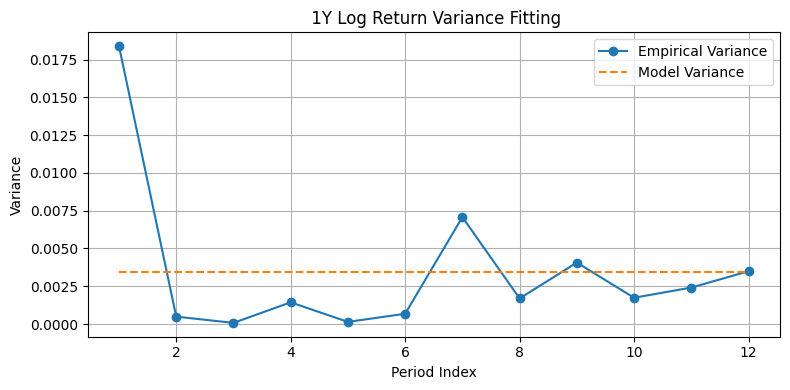

2.0681
훈련(80%) :
  σ_K (OU noise): 0.05079
  σ_S (FX noise): 0.05346



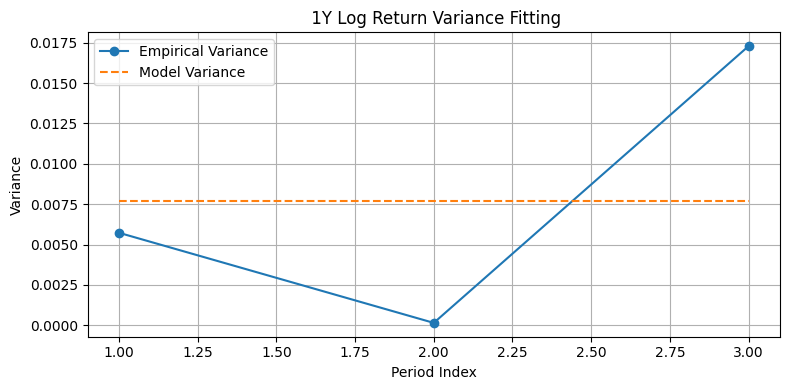

2.0681
검증(20%) :
  σ_K (OU noise): 0.04742
  σ_S (FX noise): 0.08476



In [ ]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np

# ✅ Step 0: 로그 수익률
spot_rates = df['spot_rate'].values
log_S = np.log(spot_rates)
T = len(log_S)


# ✅ Step 1: 분석 구간 설정 (8:2)
cut = int(T * 0.8)
sections = {
    '훈련(80%)': log_S[:cut],
    '검증(20%)': log_S[cut:]
}

# ✅ Step 2: 함수 정의
def logS_variance_model(t, theta, sigma_K, sigma_S):
    var_ou = (sigma_K ** 2) / (2 * theta) * (1 - np.exp(-2 * theta * t))
    var_fx = sigma_S ** 2 * t
    return var_ou + var_fx

def loss_sigma(params, t_array, empirical_var_array, theta):
    sigma_K, sigma_S = params
    if sigma_K <= 0 or sigma_S <= 0:
        return np.inf
    model_var = np.array([logS_variance_model(t, theta, sigma_K, sigma_S) for t in t_array])
    return np.sum((empirical_var_array - model_var) ** 2)

def estimate_and_plot(log_S_section, label, theta=2.0681):
    horizon = 252
    dt = horizon / 252
    starts = np.arange(0, len(log_S_section) - horizon, horizon)
    t_array = np.full(len(starts), dt)
    empirical_var_array = []

    for i in starts:
        r_log = log_S_section[i + horizon] - log_S_section[i]
        empirical_var_array.append(r_log**2)

    empirical_var_array = np.array(empirical_var_array)

    result = minimize(
        loss_sigma,
        x0=[0.05, 0.05],
        args=(t_array, empirical_var_array, theta),
        bounds=[(1e-5, 1.0), (1e-5, 1.0)]
    )

    sigma_K_est, sigma_S_est = result.x
    model_variance = [logS_variance_model(t, theta, sigma_K_est, sigma_S_est) for t in t_array]

    # ✅ 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(empirical_var_array) + 1), empirical_var_array, 'o-', label='Empirical Variance')
    plt.plot(range(1, len(model_variance) + 1), model_variance, '--', label='Model Variance')
    plt.title(' 1Y Log Return Variance Fitting')
    plt.xlabel('Period Index')
    plt.ylabel('Variance')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ✅ 결과 출력
    print(theta)
    print(f"{label} :")
    print(f"  σ_K (OU noise): {sigma_K_est:.5f}")
    print(f"  σ_S (FX noise): {sigma_S_est:.5f}\n")

# ✅ 훈련(80%) / 검증(20%) 구간 각각 실행
for label, log_S_section in sections.items():
    estimate_and_plot(log_S_section, label)

In [ ]:
# 고정 파라미터
# 고정 파라미터
theta = 2.0681
sigma_K = 0.05079
sigma_S = 0.05346

# 예측 설정
horizon = 252
t = horizon / 252

# Z값들 (단측 기준)
Z_VALUES = {
    '50': 0.674,
    '60': 0.8416,
    '70': 1.036,
    '80': 1.2816,
    '90': 1.645,
    '95': 1.96,
    '99': 2.326
}

# 데이터 8:2로 나누기
cut = int(len(df) * 0.8)
df_parts = {
    '훈련(80%)': df.iloc[:cut].reset_index(drop=True),
    '검증(20%)': df.iloc[cut:].reset_index(drop=True)
}

# 분석 함수
def evaluate_prediction(df_part, label):
    results = []
    for i in range(horizon, len(df_part) - horizon):
        S0 = df_part['spot_rate'].iloc[i]
        S_prev = df_part['spot_rate'].iloc[i - horizon]
        S1 = df_part['spot_rate'].iloc[i + horizon]

        r_int = (df_part['us_rate'].iloc[i] - df_part['kr_rate'].iloc[i]) / 100 * t
        K0 = np.log(S0 / S_prev) - r_int

        log_S0 = np.log(S0)
        E_logS_t = (
            log_S0 + r_int +
            (K0 / theta) * (1 - np.exp(-theta * t))
        )

        Var_logS_t = (sigma_S**2) * t + (sigma_K**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t))
        Std_logS_t = np.sqrt(Var_logS_t)

        row = {
            'Date': df_part['Date'].iloc[i],
            'S0': S0,
            'S1_real': S1,
            'E_S1': np.exp(E_logS_t)
        }

        for level, Z in Z_VALUES.items():
            lower = np.exp(E_logS_t - Z * Std_logS_t)
            upper = np.exp(E_logS_t + Z * Std_logS_t)
            row[f'Lower_{level}'] = lower
            row[f'Upper_{level}'] = upper
            row[f'Covered_{level}'] = lower <= S1 <= upper

        results.append(row)

    result_df = pd.DataFrame(results)

    print(f"✅ {label} 신뢰구간별 실제 환율 포함률 (1년 기준):")
    for level in Z_VALUES.keys():
        hit_rate = result_df[f'Covered_{level}'].mean()
        print(f"  - {level}% 신뢰구간: {hit_rate:.2%}")
    print()

# 훈련(80%) / 검증(20%) 구간 분석 실행
for label, df_part in df_parts.items():
    evaluate_prediction(df_part, label)

✅ 훈련(80%) 신뢰구간별 실제 환율 포함률 (1년 기준):
  - 50% 신뢰구간: 38.28%
  - 60% 신뢰구간: 47.68%
  - 70% 신뢰구간: 59.12%
  - 80% 신뢰구간: 70.30%
  - 90% 신뢰구간: 84.48%
  - 95% 신뢰구간: 90.88%
  - 99% 신뢰구간: 96.24%

✅ 검증(20%) 신뢰구간별 실제 환율 포함률 (1년 기준):
  - 50% 신뢰구간: 48.88%
  - 60% 신뢰구간: 55.27%
  - 70% 신뢰구간: 63.90%
  - 80% 신뢰구간: 75.72%
  - 90% 신뢰구간: 92.97%
  - 95% 신뢰구간: 99.68%
  - 99% 신뢰구간: 100.00%



✅ 훈련(80%) 신뢰구간별 실제 환율 포함률 (1개월 기준):
  - 60% 신뢰구간: 47.68%
  - 80% 신뢰구간: 70.30%
  - 95% 신뢰구간: 90.88%

✅ 검증(20%) 신뢰구간별 실제 환율 포함률 (1개월 기준):
  - 60% 신뢰구간: 55.27%
  - 80% 신뢰구간: 75.72%
  - 95% 신뢰구간: 99.68%



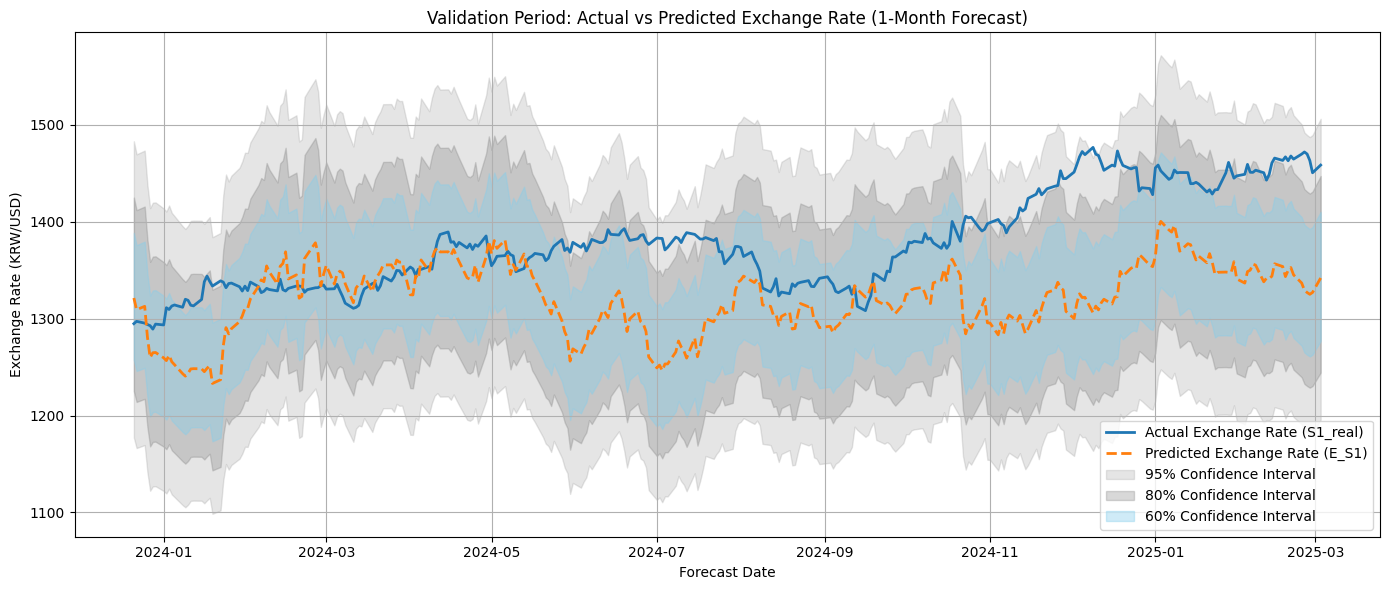

In [ ]:
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay




Z_VALUES = {
    '60': 0.8416,
    '80': 1.2816,
    '95': 1.96
}

# 데이터 8:2로 나누기
cut = int(len(df) * 0.8)
df_parts = {
    '훈련(80%)': df.iloc[:cut].reset_index(drop=True),
    '검증(20%)': df.iloc[cut:].reset_index(drop=True)
}

# 분석 및 시각화 함수
def evaluate_prediction(df_part, label):
    results = []
    for i in range(horizon, len(df_part) - horizon):
        S0 = df_part['spot_rate'].iloc[i]
        S_prev = df_part['spot_rate'].iloc[i - horizon]
        S1 = df_part['spot_rate'].iloc[i + horizon]

        r_int = (df_part['us_rate'].iloc[i] - df_part['kr_rate'].iloc[i]) / 100 * t
        K0 = np.log(S0 / S_prev) - r_int

        log_S0 = np.log(S0)
        E_logS_t = (
            log_S0 + r_int +
            (K0 / theta) * (1 - np.exp(-theta * t))
        )

        Var_logS_t = (sigma_S**2) * t + (sigma_K**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t))
        Std_logS_t = np.sqrt(Var_logS_t)

        row = {
            'Date': df_part['Date'].iloc[i],
            'S0': S0,
            'S1_real': S1,
            'E_S1': np.exp(E_logS_t)
        }

        for level, Z in Z_VALUES.items():
            lower = np.exp(E_logS_t - Z * Std_logS_t)
            upper = np.exp(E_logS_t + Z * Std_logS_t)
            row[f'Lower_{level}'] = lower
            row[f'Upper_{level}'] = upper
            row[f'Covered_{level}'] = lower <= S1 <= upper

        results.append(row)

    result_df = pd.DataFrame(results)
    result_df['Forecast_Date'] = result_df['Date'] + BDay(horizon)

    # 신뢰구간 포함률 출력
    print(f"✅ {label} 신뢰구간별 실제 환율 포함률 (1개월 기준):")
    for level in Z_VALUES:
        hit = result_df[f'Covered_{level}'].mean()
        print(f"  - {level}% 신뢰구간: {hit:.2%}")
    print()

    # 검증 구간일 때만 그래프 그리기
    if "검증" in label:
        plt.figure(figsize=(14, 6))
        plt.plot(result_df['Forecast_Date'], result_df['S1_real'], label='Actual Exchange Rate (S1_real)', linewidth=2)
        plt.plot(result_df['Forecast_Date'], result_df['E_S1'], label='Predicted Exchange Rate (E_S1)', linewidth=2, linestyle='--')

        plt.fill_between(result_df['Forecast_Date'], result_df['Lower_95'], result_df['Upper_95'],
                         color='gray', alpha=0.2, label='95% Confidence Interval')
        plt.fill_between(result_df['Forecast_Date'], result_df['Lower_80'], result_df['Upper_80'],
                         color='gray', alpha=0.3, label='80% Confidence Interval')
        plt.fill_between(result_df['Forecast_Date'], result_df['Lower_60'], result_df['Upper_60'],
                         color='skyblue', alpha=0.4, label='60% Confidence Interval')

        plt.title("Validation Period: Actual vs Predicted Exchange Rate (1-Month Forecast)")
        plt.xlabel("Forecast Date")
        plt.ylabel("Exchange Rate (KRW/USD)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# 훈련(80%) / 검증(20%) 구간 각각 실행
for label, df_part in df_parts.items():
    evaluate_prediction(df_part, label)

### 백테스팅 6개월

In [ ]:
#파라미터 계산
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 (생략하지 않고 전체 유지)
fx = pd.read_csv('fx.csv')[['날짜', '종가']]
us = pd.read_csv('us_bond.csv')[['날짜', '종가']]
kr = pd.read_csv('kr_bond.csv')[['날짜', '종가']]

fx['Date'] = pd.to_datetime(fx['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
us['Date'] = pd.to_datetime(us['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
kr['Date'] = pd.to_datetime(kr['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
fx['Close'] = fx['종가'].str.replace(",", "").astype(float)
us['Close'] = us['종가'].astype(float)
kr['Close'] = kr['종가'].astype(float)

fx = fx.rename(columns={"Close": "spot_rate"})
us = us.rename(columns={"Close": "us_rate"})
kr = kr.rename(columns={"Close": "kr_rate"})

df = fx.merge(kr, on='Date').merge(us, on='Date')
df = df.dropna().sort_values('Date').reset_index(drop=True)

# 2. K 계산 (1년)
horizon = 126 #1년
k_direct = []
date_list = []

for i in range(len(df) - horizon):
    s_now = df['spot_rate'].iloc[i]
    s_future = df['spot_rate'].iloc[i + horizon]


    r_diff_3mo = ((df['us_rate'].iloc[i] - df['kr_rate'].iloc[i]) / 100) * (horizon / 252)

    K_approx = np.log(s_future / s_now) - r_diff_3mo
    k_direct.append(K_approx)
    date_list.append(df['Date'].iloc[i + horizon])

k_df = pd.DataFrame({
    'Date': date_list,
    'K_direct': k_direct
})
#파라메터 계산
from scipy.optimize import minimize
import numpy as np

# OU 음의 로그우도 함수 (μ = 0 고정)
def ou_nll_mu_zero(params, K_series, dt):
    theta, sigma = params
    if theta <= 0 or sigma <= 0:
        return np.inf

    K_prev = K_series[:-1]
    K_next = K_series[1:]

    expected = K_prev - theta * K_prev * dt
    variance = sigma ** 2 * dt

    ll = -0.5 * np.sum(np.log(2 * np.pi * variance) + ((K_next - expected) ** 2) / variance)
    return -ll

# 데이터
K_series = np.array(k_df['K_direct'].values)
dt = 1 / 252
cut = int(len(K_series) * 0.8)

K_train = K_series[:cut]  # 80%
K_test = K_series[cut:]   # 20%

# 최적화 함수
def fit_ou(K_part, name):
    res = minimize(
        ou_nll_mu_zero,
        x0=[1.0, 0.01],  # 초기 추정값
        args=(K_part, dt),
        bounds=[(1e-5, 10), (1e-5, 1.0)]
    )
    theta, sigma = res.x
    print(f"📊 {name} 구간 OU 추정값 (μ = 0):")
    print(f"  - θ (mean reversion speed): {theta:.4f}")
    print(f"  - σ (volatility): {sigma:.4f}\n")
    return theta, sigma

# 80% / 20% 구간에 대해 추정
theta_train, sigma_train = fit_ou(K_train, "훈련(80%)")
theta_test, sigma_test = fit_ou(K_test, "검증(20%)")

📊 훈련(80%) 구간 OU 추정값 (μ = 0):
  - θ (mean reversion speed): 3.0533
  - σ (volatility): 0.1251

📊 검증(20%) 구간 OU 추정값 (μ = 0):
  - θ (mean reversion speed): 2.2730
  - σ (volatility): 0.1313



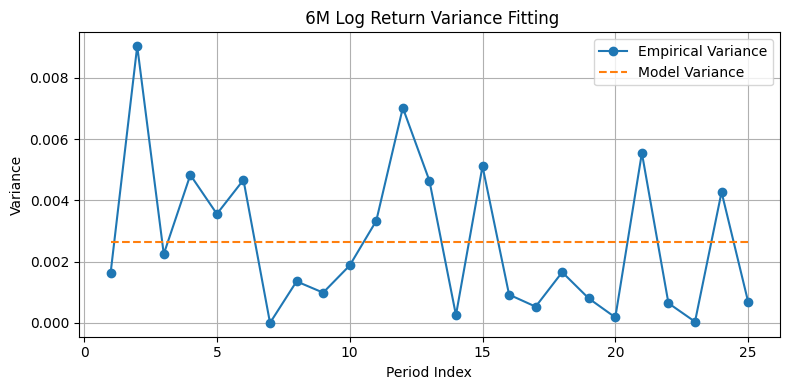

3.0533
📌 훈련(80%) :
  σ_K (OU noise): 0.05356
  σ_S (FX noise): 0.06615



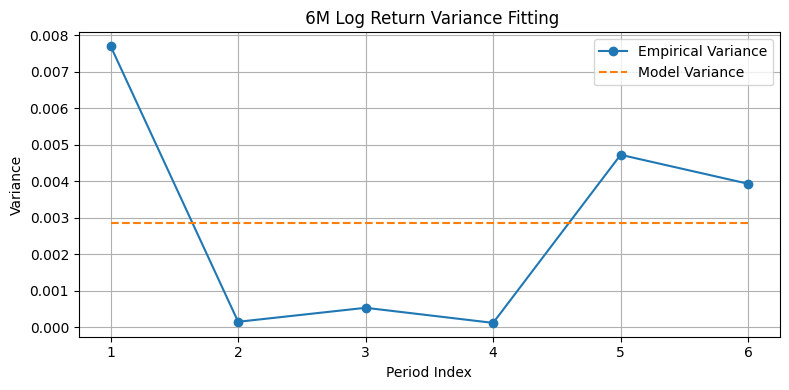

3.0533
📌 검증(20%) :
  σ_K (OU noise): 0.05327
  σ_S (FX noise): 0.06949



In [ ]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np

# ✅ Step 0: 로그 수익률
spot_rates = df['spot_rate'].values
log_S = np.log(spot_rates)
T = len(log_S)


# ✅ Step 1: 분석 구간 설정 (8:2)
cut = int(T * 0.8)
sections = {
    '훈련(80%)': log_S[:cut],
    '검증(20%)': log_S[cut:]
}

# ✅ Step 2: 함수 정의
def logS_variance_model(t, theta, sigma_K, sigma_S):
    var_ou = (sigma_K ** 2) / (2 * theta) * (1 - np.exp(-2 * theta * t))
    var_fx = sigma_S ** 2 * t
    return var_ou + var_fx

def loss_sigma(params, t_array, empirical_var_array, theta):
    sigma_K, sigma_S = params
    if sigma_K <= 0 or sigma_S <= 0:
        return np.inf
    model_var = np.array([logS_variance_model(t, theta, sigma_K, sigma_S) for t in t_array])
    return np.sum((empirical_var_array - model_var) ** 2)

def estimate_and_plot(log_S_section, label, theta=3.0533):
    horizon = 126
    dt = horizon / 252
    starts = np.arange(0, len(log_S_section) - horizon, horizon)
    t_array = np.full(len(starts), dt)
    empirical_var_array = []

    for i in starts:
        r_log = log_S_section[i + horizon] - log_S_section[i]
        empirical_var_array.append(r_log**2)

    empirical_var_array = np.array(empirical_var_array)

    result = minimize(
        loss_sigma,
        x0=[0.05, 0.05],
        args=(t_array, empirical_var_array, theta),
        bounds=[(1e-5, 1.0), (1e-5, 1.0)]
    )

    sigma_K_est, sigma_S_est = result.x
    model_variance = [logS_variance_model(t, theta, sigma_K_est, sigma_S_est) for t in t_array]

    # ✅ 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(empirical_var_array) + 1), empirical_var_array, 'o-', label='Empirical Variance')
    plt.plot(range(1, len(model_variance) + 1), model_variance, '--', label='Model Variance')
    plt.title(' 6M Log Return Variance Fitting')
    plt.xlabel('Period Index')
    plt.ylabel('Variance')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ✅ 결과 출력
    print(theta)
    print(f"📌 {label} :")
    print(f"  σ_K (OU noise): {sigma_K_est:.5f}")
    print(f"  σ_S (FX noise): {sigma_S_est:.5f}\n")

# ✅ 훈련(80%) / 검증(20%) 구간 각각 실행
for label, log_S_section in sections.items():
    estimate_and_plot(log_S_section, label)

In [ ]:
# 고정 파라미터
# 고정 파라미터
theta = 3.0533
sigma_K = 0.05356
sigma_S = 0.06615

# 예측 설정
horizon = 126
t = horizon / 252

# Z값들 (단측 기준)
Z_VALUES = {
    '50': 0.674,
    '60': 0.8416,
    '70': 1.036,
    '80': 1.2816,
    '90': 1.645,
    '95': 1.96,
    '99': 2.326
}

# 데이터 8:2로 나누기
cut = int(len(df) * 0.8)
df_parts = {
    '훈련(80%)': df.iloc[:cut].reset_index(drop=True),
    '검증(20%)': df.iloc[cut:].reset_index(drop=True)
}

# 분석 함수
def evaluate_prediction(df_part, label):
    results = []
    for i in range(horizon, len(df_part) - horizon):
        S0 = df_part['spot_rate'].iloc[i]
        S_prev = df_part['spot_rate'].iloc[i - horizon]
        S1 = df_part['spot_rate'].iloc[i + horizon]

        r_int = (df_part['us_rate'].iloc[i] - df_part['kr_rate'].iloc[i]) / 100 * t
        K0 = np.log(S0 / S_prev) - r_int

        log_S0 = np.log(S0)
        E_logS_t = (
            log_S0 + r_int +
            (K0 / theta) * (1 - np.exp(-theta * t))
        )

        Var_logS_t = (sigma_S**2) * t + (sigma_K**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t))
        Std_logS_t = np.sqrt(Var_logS_t)

        row = {
            'Date': df_part['Date'].iloc[i],
            'S0': S0,
            'S1_real': S1,
            'E_S1': np.exp(E_logS_t)
        }

        for level, Z in Z_VALUES.items():
            lower = np.exp(E_logS_t - Z * Std_logS_t)
            upper = np.exp(E_logS_t + Z * Std_logS_t)
            row[f'Lower_{level}'] = lower
            row[f'Upper_{level}'] = upper
            row[f'Covered_{level}'] = lower <= S1 <= upper

        results.append(row)

    result_df = pd.DataFrame(results)

    print(f"✅ {label} 신뢰구간별 실제 환율 포함률 (6개월 기준):")
    for level in Z_VALUES.keys():
        hit_rate = result_df[f'Covered_{level}'].mean()
        print(f"  - {level}% 신뢰구간: {hit_rate:.2%}")
    print()

# 훈련(80%) / 검증(20%) 구간 분석 실행
for label, df_part in df_parts.items():
    evaluate_prediction(df_part, label)

✅ 훈련(80%) 신뢰구간별 실제 환율 포함률 (6개월 기준):
  - 50% 신뢰구간: 43.60%
  - 60% 신뢰구간: 55.07%
  - 70% 신뢰구간: 67.44%
  - 80% 신뢰구간: 80.47%
  - 90% 신뢰구간: 91.91%
  - 95% 신뢰구간: 97.18%
  - 99% 신뢰구간: 99.87%

✅ 검증(20%) 신뢰구간별 실제 환율 포함률 (6개월 기준):
  - 50% 신뢰구간: 54.87%
  - 60% 신뢰구간: 66.73%
  - 70% 신뢰구간: 74.69%
  - 80% 신뢰구간: 82.65%
  - 90% 신뢰구간: 90.44%
  - 95% 신뢰구간: 95.58%
  - 99% 신뢰구간: 97.88%



✅ 훈련(80%) 신뢰구간별 실제 환율 포함률 (6개월 기준):
  - 60% 신뢰구간: 55.07%
  - 80% 신뢰구간: 80.47%
  - 95% 신뢰구간: 97.18%

✅ 검증(20%) 신뢰구간별 실제 환율 포함률 (6개월 기준):
  - 60% 신뢰구간: 66.73%
  - 80% 신뢰구간: 82.65%
  - 95% 신뢰구간: 95.58%



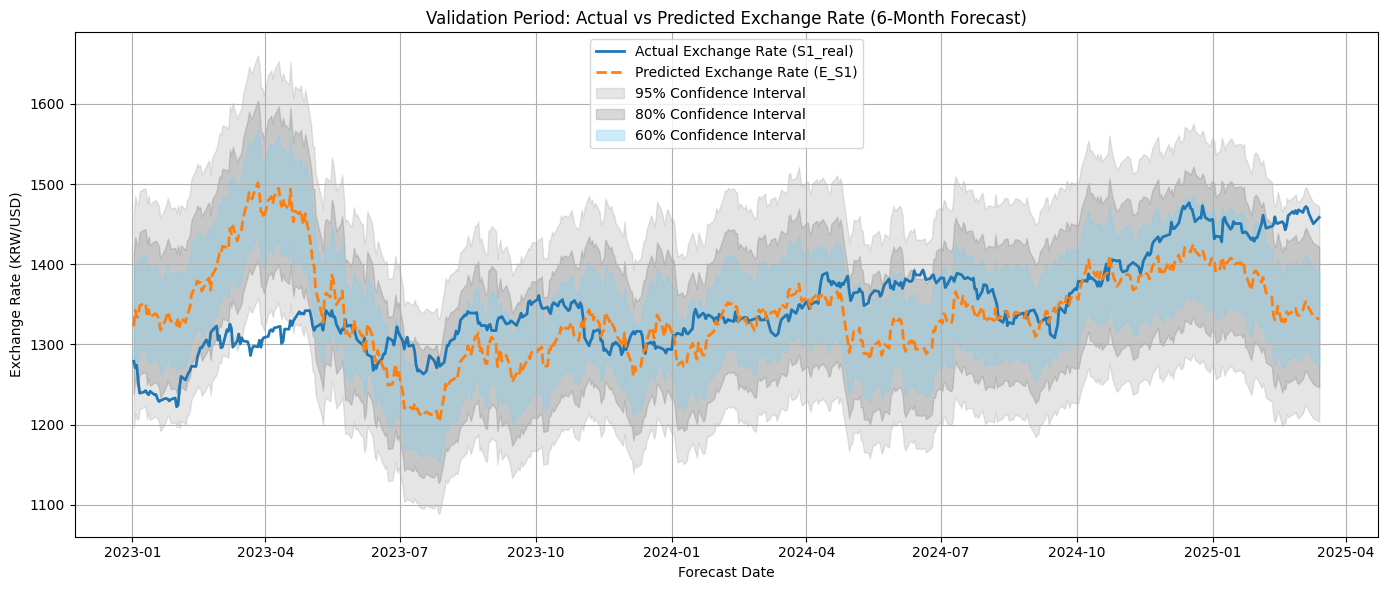

In [ ]:
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay




Z_VALUES = {
    '60': 0.8416,
    '80': 1.2816,
    '95': 1.96
}

# 데이터 8:2로 나누기
cut = int(len(df) * 0.8)
df_parts = {
    '훈련(80%)': df.iloc[:cut].reset_index(drop=True),
    '검증(20%)': df.iloc[cut:].reset_index(drop=True)
}

# 분석 및 시각화 함수
def evaluate_prediction(df_part, label):
    results = []
    for i in range(horizon, len(df_part) - horizon):
        S0 = df_part['spot_rate'].iloc[i]
        S_prev = df_part['spot_rate'].iloc[i - horizon]
        S1 = df_part['spot_rate'].iloc[i + horizon]

        r_int = (df_part['us_rate'].iloc[i] - df_part['kr_rate'].iloc[i]) / 100 * t
        K0 = np.log(S0 / S_prev) - r_int

        log_S0 = np.log(S0)
        E_logS_t = (
            log_S0 + r_int +
            (K0 / theta) * (1 - np.exp(-theta * t))
        )

        Var_logS_t = (sigma_S**2) * t + (sigma_K**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t))
        Std_logS_t = np.sqrt(Var_logS_t)

        row = {
            'Date': df_part['Date'].iloc[i],
            'S0': S0,
            'S1_real': S1,
            'E_S1': np.exp(E_logS_t)
        }

        for level, Z in Z_VALUES.items():
            lower = np.exp(E_logS_t - Z * Std_logS_t)
            upper = np.exp(E_logS_t + Z * Std_logS_t)
            row[f'Lower_{level}'] = lower
            row[f'Upper_{level}'] = upper
            row[f'Covered_{level}'] = lower <= S1 <= upper

        results.append(row)

    result_df = pd.DataFrame(results)
    result_df['Forecast_Date'] = result_df['Date'] + BDay(horizon)

    # 신뢰구간 포함률 출력
    print(f"✅ {label} 신뢰구간별 실제 환율 포함률 (6개월 기준):")
    for level in Z_VALUES:
        hit = result_df[f'Covered_{level}'].mean()
        print(f"  - {level}% 신뢰구간: {hit:.2%}")
    print()

    # 검증 구간일 때만 그래프 그리기
    if "검증" in label:
        plt.figure(figsize=(14, 6))
        plt.plot(result_df['Forecast_Date'], result_df['S1_real'], label='Actual Exchange Rate (S1_real)', linewidth=2)
        plt.plot(result_df['Forecast_Date'], result_df['E_S1'], label='Predicted Exchange Rate (E_S1)', linewidth=2, linestyle='--')

        plt.fill_between(result_df['Forecast_Date'], result_df['Lower_95'], result_df['Upper_95'],
                         color='gray', alpha=0.2, label='95% Confidence Interval')
        plt.fill_between(result_df['Forecast_Date'], result_df['Lower_80'], result_df['Upper_80'],
                         color='gray', alpha=0.3, label='80% Confidence Interval')
        plt.fill_between(result_df['Forecast_Date'], result_df['Lower_60'], result_df['Upper_60'],
                         color='skyblue', alpha=0.4, label='60% Confidence Interval')

        plt.title("Validation Period: Actual vs Predicted Exchange Rate (6-Month Forecast)")
        plt.xlabel("Forecast Date")
        plt.ylabel("Exchange Rate (KRW/USD)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# 훈련(80%) / 검증(20%) 구간 각각 실행
for label, df_part in df_parts.items():
    evaluate_prediction(df_part, label)

### 백테스팅 3개월

In [ ]:
#파라미터 계산
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 (생략하지 않고 전체 유지)
fx = pd.read_csv('fx.csv')[['날짜', '종가']]
us = pd.read_csv('us_bond.csv')[['날짜', '종가']]
kr = pd.read_csv('kr_bond.csv')[['날짜', '종가']]

fx['Date'] = pd.to_datetime(fx['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
us['Date'] = pd.to_datetime(us['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
kr['Date'] = pd.to_datetime(kr['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
fx['Close'] = fx['종가'].str.replace(",", "").astype(float)
us['Close'] = us['종가'].astype(float)
kr['Close'] = kr['종가'].astype(float)

fx = fx.rename(columns={"Close": "spot_rate"})
us = us.rename(columns={"Close": "us_rate"})
kr = kr.rename(columns={"Close": "kr_rate"})

df = fx.merge(kr, on='Date').merge(us, on='Date')
df = df.dropna().sort_values('Date').reset_index(drop=True)

# 2. K 계산 (1년)
horizon = 63  #3개월
k_direct = []
date_list = []

for i in range(len(df) - horizon):
    s_now = df['spot_rate'].iloc[i]
    s_future = df['spot_rate'].iloc[i + horizon]


    r_diff_3mo = ((df['us_rate'].iloc[i] - df['kr_rate'].iloc[i]) / 100) * (horizon / 252)

    K_approx = np.log(s_future / s_now) - r_diff_3mo
    k_direct.append(K_approx)
    date_list.append(df['Date'].iloc[i + horizon])

k_df = pd.DataFrame({
    'Date': date_list,
    'K_direct': k_direct
})
#파라메터 계산
from scipy.optimize import minimize
import numpy as np

# OU 음의 로그우도 함수 (μ = 0 고정)
def ou_nll_mu_zero(params, K_series, dt):
    theta, sigma = params
    if theta <= 0 or sigma <= 0:
        return np.inf

    K_prev = K_series[:-1]
    K_next = K_series[1:]

    expected = K_prev - theta * K_prev * dt
    variance = sigma ** 2 * dt

    ll = -0.5 * np.sum(np.log(2 * np.pi * variance) + ((K_next - expected) ** 2) / variance)
    return -ll

# 데이터
K_series = np.array(k_df['K_direct'].values)
dt = 1 / 252
cut = int(len(K_series) * 0.8)

K_train = K_series[:cut]  # 80%
K_test = K_series[cut:]   # 20%

# 최적화 함수
def fit_ou(K_part, name):
    res = minimize(
        ou_nll_mu_zero,
        x0=[1.0, 0.01],  # 초기 추정값
        args=(K_part, dt),
        bounds=[(1e-5, 10), (1e-5, 1.0)]
    )
    theta, sigma = res.x
    print(f"📊 {name} 구간 OU 추정값 (μ = 0):")
    print(f"  - θ (mean reversion speed): {theta:.4f}")
    print(f"  - σ (volatility): {sigma:.4f}\n")
    return theta, sigma

# 80% / 20% 구간에 대해 추정
theta_train, sigma_train = fit_ou(K_train, "훈련(80%)")
theta_test, sigma_test = fit_ou(K_test, "검증(20%)")

📊 훈련(80%) 구간 OU 추정값 (μ = 0):
  - θ (mean reversion speed): 5.1707
  - σ (volatility): 0.1293

📊 검증(20%) 구간 OU 추정값 (μ = 0):
  - θ (mean reversion speed): 3.5704
  - σ (volatility): 0.1328



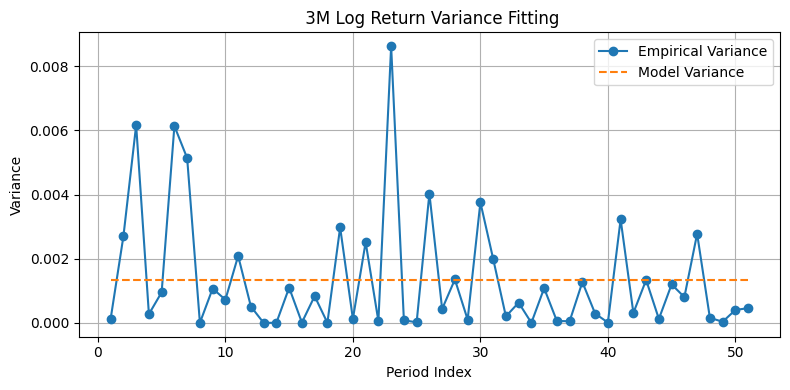

5.1707
📌 훈련(80%) :
  σ_K (OU noise): 0.05393
  σ_S (FX noise): 0.06578



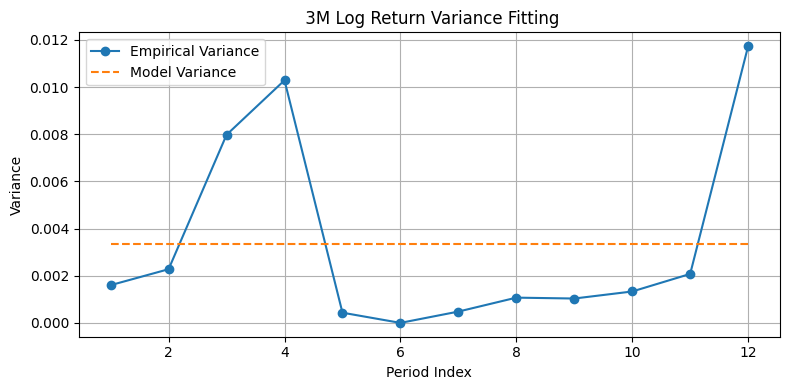

5.1707
📌 검증(20%) :
  σ_K (OU noise): 0.06182
  σ_S (FX noise): 0.10989



In [ ]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np

# ✅ Step 0: 로그 수익률
spot_rates = df['spot_rate'].values
log_S = np.log(spot_rates)
T = len(log_S)


# ✅ Step 1: 분석 구간 설정 (8:2)
cut = int(T * 0.8)
sections = {
    '훈련(80%)': log_S[:cut],
    '검증(20%)': log_S[cut:]
}

# ✅ Step 2: 함수 정의
def logS_variance_model(t, theta, sigma_K, sigma_S):
    var_ou = (sigma_K ** 2) / (2 * theta) * (1 - np.exp(-2 * theta * t))
    var_fx = sigma_S ** 2 * t
    return var_ou + var_fx

def loss_sigma(params, t_array, empirical_var_array, theta):
    sigma_K, sigma_S = params
    if sigma_K <= 0 or sigma_S <= 0:
        return np.inf
    model_var = np.array([logS_variance_model(t, theta, sigma_K, sigma_S) for t in t_array])
    return np.sum((empirical_var_array - model_var) ** 2)

def estimate_and_plot(log_S_section, label, theta=5.1707):
    horizon = 63
    dt = horizon / 252
    starts = np.arange(0, len(log_S_section) - horizon, horizon)
    t_array = np.full(len(starts), dt)
    empirical_var_array = []

    for i in starts:
        r_log = log_S_section[i + horizon] - log_S_section[i]
        empirical_var_array.append(r_log**2)

    empirical_var_array = np.array(empirical_var_array)

    result = minimize(
        loss_sigma,
        x0=[0.05, 0.05],
        args=(t_array, empirical_var_array, theta),
        bounds=[(1e-5, 1.0), (1e-5, 1.0)]
    )

    sigma_K_est, sigma_S_est = result.x
    model_variance = [logS_variance_model(t, theta, sigma_K_est, sigma_S_est) for t in t_array]

    # ✅ 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(empirical_var_array) + 1), empirical_var_array, 'o-', label='Empirical Variance')
    plt.plot(range(1, len(model_variance) + 1), model_variance, '--', label='Model Variance')
    plt.title(' 3M Log Return Variance Fitting')
    plt.xlabel('Period Index')
    plt.ylabel('Variance')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ✅ 결과 출력
    print(theta)
    print(f"📌 {label} :")
    print(f"  σ_K (OU noise): {sigma_K_est:.5f}")
    print(f"  σ_S (FX noise): {sigma_S_est:.5f}\n")

# ✅ 훈련(80%) / 검증(20%) 구간 각각 실행
for label, log_S_section in sections.items():
    estimate_and_plot(log_S_section, label)

In [ ]:
# 고정 파라미터
# 고정 파라미터
theta = 5.1707
sigma_K = 0.05393
sigma_S = 0.06578

# 예측 설정
horizon = 63
t = horizon / 252

# Z값들 (단측 기준)
Z_VALUES = {
    '50': 0.674,
    '60': 0.8416,
    '70': 1.036,
    '80': 1.2816,
    '90': 1.645,
    '95': 1.96,
    '99': 2.326
}

# 데이터 8:2로 나누기
cut = int(len(df) * 0.8)
df_parts = {
    '훈련(80%)': df.iloc[:cut].reset_index(drop=True),
    '검증(20%)': df.iloc[cut:].reset_index(drop=True)
}

# 분석 함수
def evaluate_prediction(df_part, label):
    results = []
    for i in range(horizon, len(df_part) - horizon):
        S0 = df_part['spot_rate'].iloc[i]
        S_prev = df_part['spot_rate'].iloc[i - horizon]
        S1 = df_part['spot_rate'].iloc[i + horizon]

        r_int = (df_part['us_rate'].iloc[i] - df_part['kr_rate'].iloc[i]) / 100 * t
        K0 = np.log(S0 / S_prev) - r_int

        log_S0 = np.log(S0)
        E_logS_t = (
            log_S0 + r_int +
            (K0 / theta) * (1 - np.exp(-theta * t))
        )

        Var_logS_t = (sigma_S**2) * t + (sigma_K**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t))
        Std_logS_t = np.sqrt(Var_logS_t)

        row = {
            'Date': df_part['Date'].iloc[i],
            'S0': S0,
            'S1_real': S1,
            'E_S1': np.exp(E_logS_t)
        }

        for level, Z in Z_VALUES.items():
            lower = np.exp(E_logS_t - Z * Std_logS_t)
            upper = np.exp(E_logS_t + Z * Std_logS_t)
            row[f'Lower_{level}'] = lower
            row[f'Upper_{level}'] = upper
            row[f'Covered_{level}'] = lower <= S1 <= upper

        results.append(row)

    result_df = pd.DataFrame(results)

    print(f"✅ {label} 신뢰구간별 실제 환율 포함률 (3개월 기준):")
    for level in Z_VALUES.keys():
        hit_rate = result_df[f'Covered_{level}'].mean()
        print(f"  - {level}% 신뢰구간: {hit_rate:.2%}")
    print()

# 훈련(80%) / 검증(20%) 구간 분석 실행
for label, df_part in df_parts.items():
    evaluate_prediction(df_part, label)

✅ 훈련(80%) 신뢰구간별 실제 환율 포함률 (3개월 기준):
  - 50% 신뢰구간: 47.58%
  - 60% 신뢰구간: 56.08%
  - 70% 신뢰구간: 65.50%
  - 80% 신뢰구간: 76.83%
  - 90% 신뢰구간: 88.45%
  - 95% 신뢰구간: 93.70%
  - 99% 신뢰구간: 97.36%

✅ 검증(20%) 신뢰구간별 실제 환율 포함률 (3개월 기준):
  - 50% 신뢰구간: 36.90%
  - 60% 신뢰구간: 47.61%
  - 70% 신뢰구간: 58.32%
  - 80% 신뢰구간: 66.43%
  - 90% 신뢰구간: 75.11%
  - 95% 신뢰구간: 81.91%
  - 99% 신뢰구간: 89.15%



✅ 훈련(80%) 신뢰구간별 실제 환율 포함률 (3개월 기준):
  - 60% 신뢰구간: 56.08%
  - 80% 신뢰구간: 76.83%
  - 95% 신뢰구간: 93.70%

✅ 검증(20%) 신뢰구간별 실제 환율 포함률 (3개월 기준):
  - 60% 신뢰구간: 47.61%
  - 80% 신뢰구간: 66.43%
  - 95% 신뢰구간: 81.91%



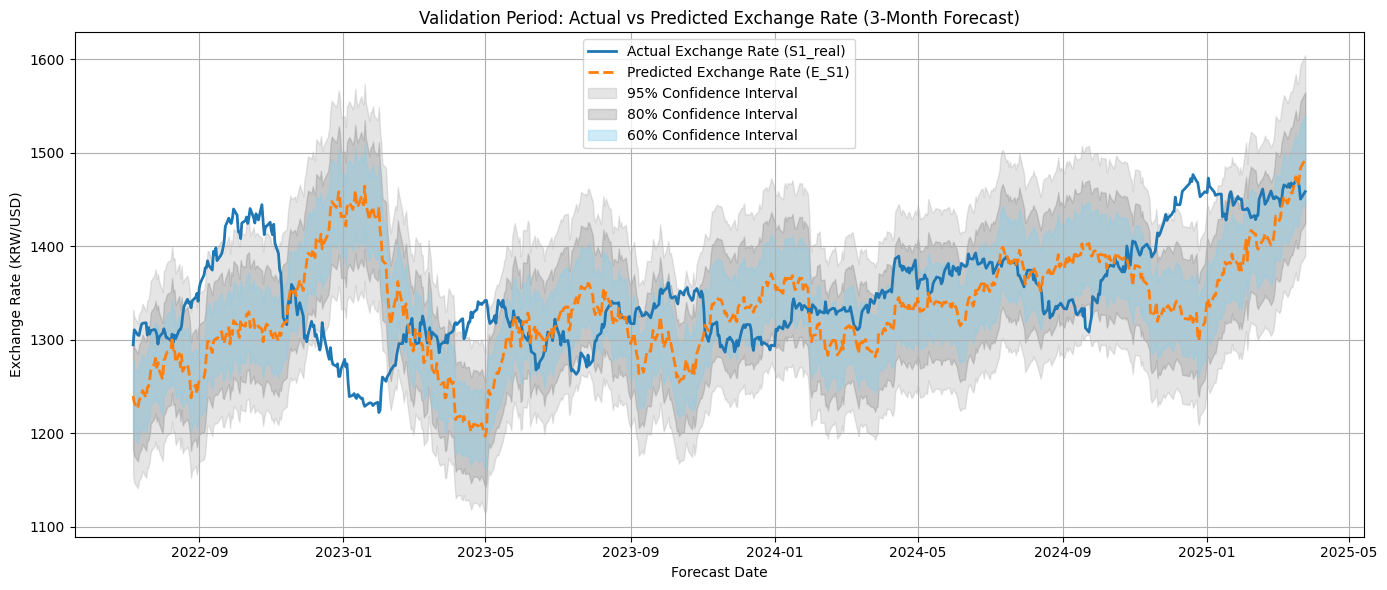

In [ ]:
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay




Z_VALUES = {
    '60': 0.8416,
    '80': 1.2816,
    '95': 1.96
}

# 데이터 8:2로 나누기
cut = int(len(df) * 0.8)
df_parts = {
    '훈련(80%)': df.iloc[:cut].reset_index(drop=True),
    '검증(20%)': df.iloc[cut:].reset_index(drop=True)
}

# 분석 및 시각화 함수
def evaluate_prediction(df_part, label):
    results = []
    for i in range(horizon, len(df_part) - horizon):
        S0 = df_part['spot_rate'].iloc[i]
        S_prev = df_part['spot_rate'].iloc[i - horizon]
        S1 = df_part['spot_rate'].iloc[i + horizon]

        r_int = (df_part['us_rate'].iloc[i] - df_part['kr_rate'].iloc[i]) / 100 * t
        K0 = np.log(S0 / S_prev) - r_int

        log_S0 = np.log(S0)
        E_logS_t = (
            log_S0 + r_int +
            (K0 / theta) * (1 - np.exp(-theta * t))
        )

        Var_logS_t = (sigma_S**2) * t + (sigma_K**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t))
        Std_logS_t = np.sqrt(Var_logS_t)

        row = {
            'Date': df_part['Date'].iloc[i],
            'S0': S0,
            'S1_real': S1,
            'E_S1': np.exp(E_logS_t)
        }

        for level, Z in Z_VALUES.items():
            lower = np.exp(E_logS_t - Z * Std_logS_t)
            upper = np.exp(E_logS_t + Z * Std_logS_t)
            row[f'Lower_{level}'] = lower
            row[f'Upper_{level}'] = upper
            row[f'Covered_{level}'] = lower <= S1 <= upper

        results.append(row)

    result_df = pd.DataFrame(results)
    result_df['Forecast_Date'] = result_df['Date'] + BDay(horizon)

    # 신뢰구간 포함률 출력
    print(f"✅ {label} 신뢰구간별 실제 환율 포함률 (3개월 기준):")
    for level in Z_VALUES:
        hit = result_df[f'Covered_{level}'].mean()
        print(f"  - {level}% 신뢰구간: {hit:.2%}")
    print()

    # 검증 구간일 때만 그래프 그리기
    if "검증" in label:
        plt.figure(figsize=(14, 6))
        plt.plot(result_df['Forecast_Date'], result_df['S1_real'], label='Actual Exchange Rate (S1_real)', linewidth=2)
        plt.plot(result_df['Forecast_Date'], result_df['E_S1'], label='Predicted Exchange Rate (E_S1)', linewidth=2, linestyle='--')

        plt.fill_between(result_df['Forecast_Date'], result_df['Lower_95'], result_df['Upper_95'],
                         color='gray', alpha=0.2, label='95% Confidence Interval')
        plt.fill_between(result_df['Forecast_Date'], result_df['Lower_80'], result_df['Upper_80'],
                         color='gray', alpha=0.3, label='80% Confidence Interval')
        plt.fill_between(result_df['Forecast_Date'], result_df['Lower_60'], result_df['Upper_60'],
                         color='skyblue', alpha=0.4, label='60% Confidence Interval')

        plt.title("Validation Period: Actual vs Predicted Exchange Rate (3-Month Forecast)")
        plt.xlabel("Forecast Date")
        plt.ylabel("Exchange Rate (KRW/USD)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# 훈련(80%) / 검증(20%) 구간 각각 실행
for label, df_part in df_parts.items():
    evaluate_prediction(df_part, label)

### 1개월

In [ ]:
#파라미터 계산
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 (생략하지 않고 전체 유지)
fx = pd.read_csv('fx.csv')[['날짜', '종가']]
us = pd.read_csv('us_bond.csv')[['날짜', '종가']]
kr = pd.read_csv('kr_bond.csv')[['날짜', '종가']]

fx['Date'] = pd.to_datetime(fx['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
us['Date'] = pd.to_datetime(us['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
kr['Date'] = pd.to_datetime(kr['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
fx['Close'] = fx['종가'].str.replace(",", "").astype(float)
us['Close'] = us['종가'].astype(float)
kr['Close'] = kr['종가'].astype(float)

fx = fx.rename(columns={"Close": "spot_rate"})
us = us.rename(columns={"Close": "us_rate"})
kr = kr.rename(columns={"Close": "kr_rate"})

df = fx.merge(kr, on='Date').merge(us, on='Date')
df = df.dropna().sort_values('Date').reset_index(drop=True)

# 2. K 계산 (1년)
horizon = 21  #3개월
k_direct = []
date_list = []

for i in range(len(df) - horizon):
    s_now = df['spot_rate'].iloc[i]
    s_future = df['spot_rate'].iloc[i + horizon]


    r_diff_3mo = ((df['us_rate'].iloc[i] - df['kr_rate'].iloc[i]) / 100) * (horizon / 252)

    K_approx = np.log(s_future / s_now) - r_diff_3mo
    k_direct.append(K_approx)
    date_list.append(df['Date'].iloc[i + horizon])

k_df = pd.DataFrame({
    'Date': date_list,
    'K_direct': k_direct
})
#파라메터 계산
from scipy.optimize import minimize
import numpy as np

# OU 음의 로그우도 함수 (μ = 0 고정)
def ou_nll_mu_zero(params, K_series, dt):
    theta, sigma = params
    if theta <= 0 or sigma <= 0:
        return np.inf

    K_prev = K_series[:-1]
    K_next = K_series[1:]

    expected = K_prev - theta * K_prev * dt
    variance = sigma ** 2 * dt

    ll = -0.5 * np.sum(np.log(2 * np.pi * variance) + ((K_next - expected) ** 2) / variance)
    return -ll

# 데이터
K_series = np.array(k_df['K_direct'].values)
dt = 1 / 252
cut = int(len(K_series) * 0.8)

K_train = K_series[:cut]  # 80%
K_test = K_series[cut:]   # 20%

# 최적화 함수
def fit_ou(K_part, name):
    res = minimize(
        ou_nll_mu_zero,
        x0=[1.0, 0.01],  # 초기 추정값
        args=(K_part, dt),
        bounds=[(1e-5, 100), (1e-5, 1.0)]
    )
    theta, sigma = res.x
    print(f"📊 {name} 구간 OU 추정값 (μ = 0):")
    print(f"  - θ (mean reversion speed): {theta:.4f}")
    print(f"  - σ (volatility): {sigma:.4f}\n")
    return theta, sigma

# 80% / 20% 구간에 대해 추정
theta_train, sigma_train = fit_ou(K_train, "훈련(80%)")
theta_test, sigma_test = fit_ou(K_test, "검증(20%)")

📊 훈련(80%) 구간 OU 추정값 (μ = 0):
  - θ (mean reversion speed): 12.8322
  - σ (volatility): 0.1307

📊 검증(20%) 구간 OU 추정값 (μ = 0):
  - θ (mean reversion speed): 10.9588
  - σ (volatility): 0.1295



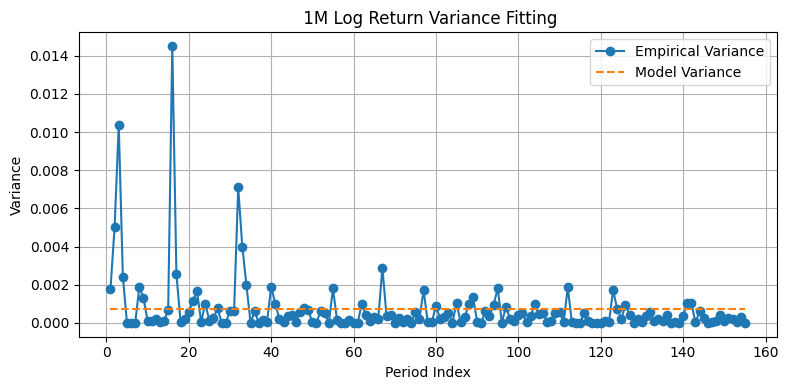

12.8322
📌 훈련(80%) :
  σ_K (OU noise): 0.05194
  σ_S (FX noise): 0.08551



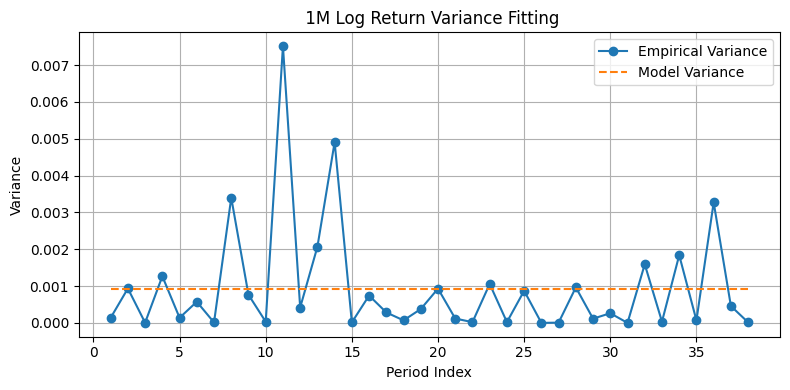

12.8322
📌 검증(20%) :
  σ_K (OU noise): 0.06693
  σ_S (FX noise): 0.09663



In [ ]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np

# ✅ Step 0: 로그 수익률
spot_rates = df['spot_rate'].values
log_S = np.log(spot_rates)
T = len(log_S)


# ✅ Step 1: 분석 구간 설정 (8:2)
cut = int(T * 0.8)
sections = {
    '훈련(80%)': log_S[:cut],
    '검증(20%)': log_S[cut:]
}

# ✅ Step 2: 함수 정의
def logS_variance_model(t, theta, sigma_K, sigma_S):
    var_ou = (sigma_K ** 2) / (2 * theta) * (1 - np.exp(-2 * theta * t))
    var_fx = sigma_S ** 2 * t
    return var_ou + var_fx

def loss_sigma(params, t_array, empirical_var_array, theta):
    sigma_K, sigma_S = params
    if sigma_K <= 0 or sigma_S <= 0:
        return np.inf
    model_var = np.array([logS_variance_model(t, theta, sigma_K, sigma_S) for t in t_array])
    return np.sum((empirical_var_array - model_var) ** 2)

def estimate_and_plot(log_S_section, label, theta=12.8322):
    horizon = 21
    dt = horizon / 252
    starts = np.arange(0, len(log_S_section) - horizon, horizon)
    t_array = np.full(len(starts), dt)
    empirical_var_array = []

    for i in starts:
        r_log = log_S_section[i + horizon] - log_S_section[i]
        empirical_var_array.append(r_log**2)

    empirical_var_array = np.array(empirical_var_array)

    result = minimize(
        loss_sigma,
        x0=[0.05, 0.05],
        args=(t_array, empirical_var_array, theta),
        bounds=[(1e-5, 1.0), (1e-5, 1.0)]
    )

    sigma_K_est, sigma_S_est = result.x
    model_variance = [logS_variance_model(t, theta, sigma_K_est, sigma_S_est) for t in t_array]

    # ✅ 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(empirical_var_array) + 1), empirical_var_array, 'o-', label='Empirical Variance')
    plt.plot(range(1, len(model_variance) + 1), model_variance, '--', label='Model Variance')
    plt.title(' 1M Log Return Variance Fitting')
    plt.xlabel('Period Index')
    plt.ylabel('Variance')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ✅ 결과 출력
    print(theta)
    print(f"📌 {label} :")
    print(f"  σ_K (OU noise): {sigma_K_est:.5f}")
    print(f"  σ_S (FX noise): {sigma_S_est:.5f}\n")

# ✅ 훈련(80%) / 검증(20%) 구간 각각 실행
for label, log_S_section in sections.items():
    estimate_and_plot(log_S_section, label)

In [ ]:
# 고정 파라미터
# 고정 파라미터
theta = 12.8322
sigma_K = 0.06693
sigma_S = 0.09663

# 예측 설정
horizon = 21
t = horizon / 252

# Z값들 (단측 기준)
Z_VALUES = {
    '50': 0.674,
    '60': 0.8416,
    '70': 1.036,
    '80': 1.2816,
    '90': 1.645,
    '95': 1.96,
    '99': 2.326
}

# 데이터 8:2로 나누기
cut = int(len(df) * 0.8)
df_parts = {
    '훈련(80%)': df.iloc[:cut].reset_index(drop=True),
    '검증(20%)': df.iloc[cut:].reset_index(drop=True)
}

# 분석 함수
def evaluate_prediction(df_part, label):
    results = []
    for i in range(horizon, len(df_part) - horizon):
        S0 = df_part['spot_rate'].iloc[i]
        S_prev = df_part['spot_rate'].iloc[i - horizon]
        S1 = df_part['spot_rate'].iloc[i + horizon]

        r_int = (df_part['us_rate'].iloc[i] - df_part['kr_rate'].iloc[i]) / 100 * t
        K0 = np.log(S0 / S_prev) - r_int

        log_S0 = np.log(S0)
        E_logS_t = (
            log_S0 + r_int +
            (K0 / theta) * (1 - np.exp(-theta * t))
        )

        Var_logS_t = (sigma_S**2) * t + (sigma_K**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t))
        Std_logS_t = np.sqrt(Var_logS_t)

        row = {
            'Date': df_part['Date'].iloc[i],
            'S0': S0,
            'S1_real': S1,
            'E_S1': np.exp(E_logS_t)
        }

        for level, Z in Z_VALUES.items():
            lower = np.exp(E_logS_t - Z * Std_logS_t)
            upper = np.exp(E_logS_t + Z * Std_logS_t)
            row[f'Lower_{level}'] = lower
            row[f'Upper_{level}'] = upper
            row[f'Covered_{level}'] = lower <= S1 <= upper

        results.append(row)

    result_df = pd.DataFrame(results)

    print(f"✅ {label} 신뢰구간별 실제 환율 포함률 (1개월 기준):")
    for level in Z_VALUES.keys():
        hit_rate = result_df[f'Covered_{level}'].mean()
        print(f"  - {level}% 신뢰구간: {hit_rate:.2%}")
    print()

# 훈련(80%) / 검증(20%) 구간 분석 실행
for label, df_part in df_parts.items():
    evaluate_prediction(df_part, label)

✅ 훈련(80%) 신뢰구간별 실제 환율 포함률 (1개월 기준):
  - 50% 신뢰구간: 64.72%
  - 60% 신뢰구간: 75.45%
  - 70% 신뢰구간: 85.06%
  - 80% 신뢰구간: 91.48%
  - 90% 신뢰구간: 95.75%
  - 95% 신뢰구간: 97.55%
  - 99% 신뢰구간: 98.23%

✅ 검증(20%) 신뢰구간별 실제 환율 포함률 (1개월 기준):
  - 50% 신뢰구간: 56.90%
  - 60% 신뢰구간: 66.19%
  - 70% 신뢰구간: 74.32%
  - 80% 신뢰구간: 82.84%
  - 90% 신뢰구간: 92.13%
  - 95% 신뢰구간: 96.77%
  - 99% 신뢰구간: 98.71%



✅ 훈련(80%) 신뢰구간별 실제 환율 포함률 (1개월 기준):
  - 60% 신뢰구간: 75.45%
  - 80% 신뢰구간: 91.48%
  - 95% 신뢰구간: 97.55%

✅ 검증(20%) 신뢰구간별 실제 환율 포함률 (1개월 기준):
  - 60% 신뢰구간: 66.19%
  - 80% 신뢰구간: 82.84%
  - 95% 신뢰구간: 96.77%



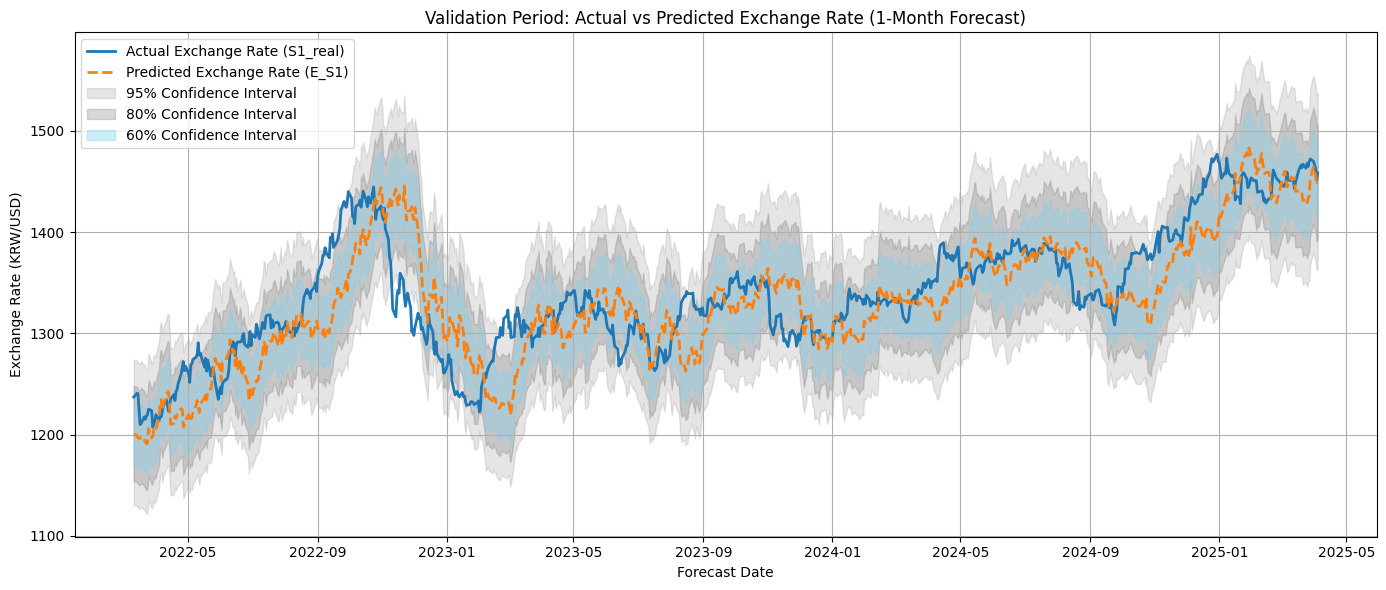

In [ ]:
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay




Z_VALUES = {
    '60': 0.8416,
    '80': 1.2816,
    '95': 1.96
}

# 데이터 8:2로 나누기
cut = int(len(df) * 0.8)
df_parts = {
    '훈련(80%)': df.iloc[:cut].reset_index(drop=True),
    '검증(20%)': df.iloc[cut:].reset_index(drop=True)
}

# 분석 및 시각화 함수
def evaluate_prediction(df_part, label):
    results = []
    for i in range(horizon, len(df_part) - horizon):
        S0 = df_part['spot_rate'].iloc[i]
        S_prev = df_part['spot_rate'].iloc[i - horizon]
        S1 = df_part['spot_rate'].iloc[i + horizon]

        r_int = (df_part['us_rate'].iloc[i] - df_part['kr_rate'].iloc[i]) / 100 * t
        K0 = np.log(S0 / S_prev) - r_int

        log_S0 = np.log(S0)
        E_logS_t = (
            log_S0 + r_int +
            (K0 / theta) * (1 - np.exp(-theta * t))
        )

        Var_logS_t = (sigma_S**2) * t + (sigma_K**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t))
        Std_logS_t = np.sqrt(Var_logS_t)

        row = {
            'Date': df_part['Date'].iloc[i],
            'S0': S0,
            'S1_real': S1,
            'E_S1': np.exp(E_logS_t)
        }

        for level, Z in Z_VALUES.items():
            lower = np.exp(E_logS_t - Z * Std_logS_t)
            upper = np.exp(E_logS_t + Z * Std_logS_t)
            row[f'Lower_{level}'] = lower
            row[f'Upper_{level}'] = upper
            row[f'Covered_{level}'] = lower <= S1 <= upper

        results.append(row)

    result_df = pd.DataFrame(results)
    result_df['Forecast_Date'] = result_df['Date'] + BDay(horizon)

    # 신뢰구간 포함률 출력
    print(f"✅ {label} 신뢰구간별 실제 환율 포함률 (1개월 기준):")
    for level in Z_VALUES:
        hit = result_df[f'Covered_{level}'].mean()
        print(f"  - {level}% 신뢰구간: {hit:.2%}")
    print()

    # 검증 구간일 때만 그래프 그리기
    if "검증" in label:
        plt.figure(figsize=(14, 6))
        plt.plot(result_df['Forecast_Date'], result_df['S1_real'], label='Actual Exchange Rate (S1_real)', linewidth=2)
        plt.plot(result_df['Forecast_Date'], result_df['E_S1'], label='Predicted Exchange Rate (E_S1)', linewidth=2, linestyle='--')

        plt.fill_between(result_df['Forecast_Date'], result_df['Lower_95'], result_df['Upper_95'],
                         color='gray', alpha=0.2, label='95% Confidence Interval')
        plt.fill_between(result_df['Forecast_Date'], result_df['Lower_80'], result_df['Upper_80'],
                         color='gray', alpha=0.3, label='80% Confidence Interval')
        plt.fill_between(result_df['Forecast_Date'], result_df['Lower_60'], result_df['Upper_60'],
                         color='skyblue', alpha=0.4, label='60% Confidence Interval')

        plt.title("Validation Period: Actual vs Predicted Exchange Rate (1-Month Forecast)")
        plt.xlabel("Forecast Date")
        plt.ylabel("Exchange Rate (KRW/USD)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# 훈련(80%) / 검증(20%) 구간 각각 실행
for label, df_part in df_parts.items():
    evaluate_prediction(df_part, label)

### 2주

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 (생략하지 않고 전체 유지)
fx = pd.read_csv('fx.csv')[['날짜', '종가']]
us = pd.read_csv('us_bond.csv')[['날짜', '종가']]
kr = pd.read_csv('kr_bond.csv')[['날짜', '종가']]

fx['Date'] = pd.to_datetime(fx['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
us['Date'] = pd.to_datetime(us['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
kr['Date'] = pd.to_datetime(kr['날짜'].str.replace(" ", ""), format="%Y-%m-%d")
fx['Close'] = fx['종가'].str.replace(",", "").astype(float)
us['Close'] = us['종가'].astype(float)
kr['Close'] = kr['종가'].astype(float)

fx = fx.rename(columns={"Close": "spot_rate"})
us = us.rename(columns={"Close": "us_rate"})
kr = kr.rename(columns={"Close": "kr_rate"})

df = fx.merge(kr, on='Date').merge(us, on='Date')
df = df.dropna().sort_values('Date').reset_index(drop=True)

# 2. K 계산
horizon = 10  #주
k_direct = []
date_list = []

for i in range(len(df) - horizon):
    s_now = df['spot_rate'].iloc[i]
    s_future = df['spot_rate'].iloc[i + horizon]


    r_diff_3mo = ((df['us_rate'].iloc[i] - df['kr_rate'].iloc[i]) / 100) * (horizon / 252)

    K_approx = np.log(s_future / s_now) - r_diff_3mo
    k_direct.append(K_approx)
    date_list.append(df['Date'].iloc[i + horizon])

k_df = pd.DataFrame({
    'Date': date_list,
    'K_direct': k_direct
})
#파라메터 계산
from scipy.optimize import minimize
import numpy as np

# OU 음의 로그우도 함수 (μ = 0 고정)
def ou_nll_mu_zero(params, K_series, dt):
    theta, sigma = params
    if theta <= 0 or sigma <= 0:
        return np.inf

    K_prev = K_series[:-1]
    K_next = K_series[1:]

    expected = K_prev - theta * K_prev * dt
    variance = sigma ** 2 * dt

    ll = -0.5 * np.sum(np.log(2 * np.pi * variance) + ((K_next - expected) ** 2) / variance)
    return -ll

# 데이터
K_series = np.array(k_df['K_direct'].values)
dt = 1 / 252
cut = int(len(K_series) * 0.8)

K_train = K_series[:cut]  # 80%
K_test = K_series[cut:]   # 20%

# 최적화 함수
def fit_ou(K_part, name):
    res = minimize(
        ou_nll_mu_zero,
        x0=[1.0, 0.01],  # 초기 추정값
        args=(K_part, dt),
        bounds=[(1e-5, 100), (1e-5, 1.0)]
    )
    theta, sigma = res.x
    print(f"📊 {name} 구간 OU 추정값 (μ = 0):")
    print(f"  - θ (mean reversion speed): {theta:.4f}")
    print(f"  - σ (volatility): {sigma:.4f}\n")
    return theta, sigma

# 80% / 20% 구간에 대해 추정
theta_train, sigma_train = fit_ou(K_train, "훈련(80%)")
theta_test, sigma_test = fit_ou(K_test, "검증(20%)")

📊 훈련(80%) 구간 OU 추정값 (μ = 0):
  - θ (mean reversion speed): 25.7113
  - σ (volatility): 0.1284

📊 검증(20%) 구간 OU 추정값 (μ = 0):
  - θ (mean reversion speed): 28.4406
  - σ (volatility): 0.1314



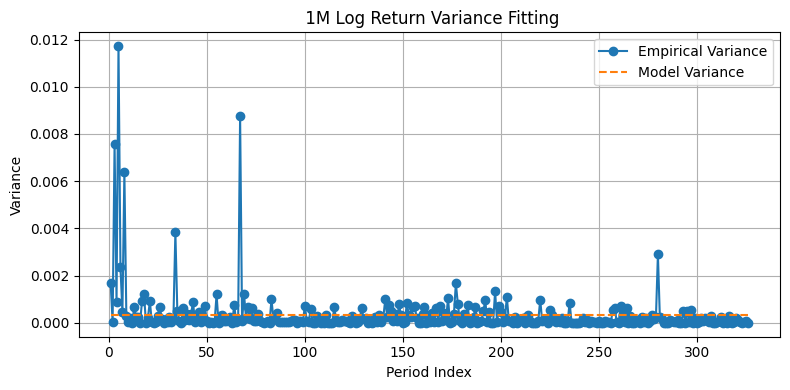

25.7113
📌 훈련(80%) :
  σ_K (OU noise): 0.05500
  σ_S (FX noise): 0.08662



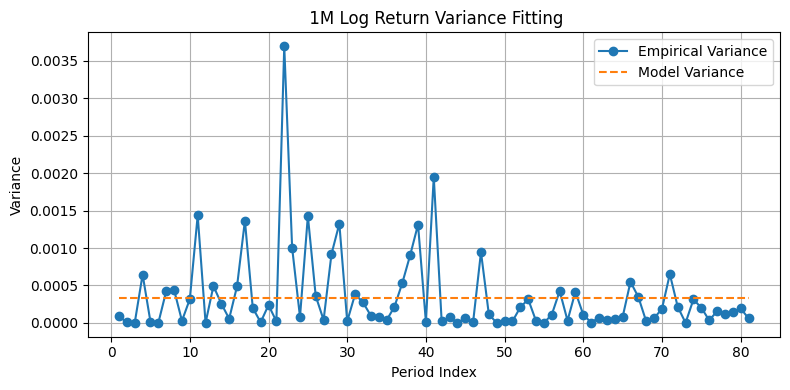

25.7113
📌 검증(20%) :
  σ_K (OU noise): 0.05321
  σ_S (FX noise): 0.08551



In [ ]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np

# ✅ Step 0: 로그 수익률
spot_rates = df['spot_rate'].values
log_S = np.log(spot_rates)
T = len(log_S)


# ✅ Step 1: 분석 구간 설정 (8:2)
cut = int(T * 0.8)
sections = {
    '훈련(80%)': log_S[:cut],
    '검증(20%)': log_S[cut:]
}

# ✅ Step 2: 함수 정의
def logS_variance_model(t, theta, sigma_K, sigma_S):
    var_ou = (sigma_K ** 2) / (2 * theta) * (1 - np.exp(-2 * theta * t))
    var_fx = sigma_S ** 2 * t
    return var_ou + var_fx

def loss_sigma(params, t_array, empirical_var_array, theta):
    sigma_K, sigma_S = params
    if sigma_K <= 0 or sigma_S <= 0:
        return np.inf
    model_var = np.array([logS_variance_model(t, theta, sigma_K, sigma_S) for t in t_array])
    return np.sum((empirical_var_array - model_var) ** 2)

def estimate_and_plot(log_S_section, label, theta=25.7113):
    horizon = 10
    dt = horizon / 252
    starts = np.arange(0, len(log_S_section) - horizon, horizon)
    t_array = np.full(len(starts), dt)
    empirical_var_array = []

    for i in starts:
        r_log = log_S_section[i + horizon] - log_S_section[i]
        empirical_var_array.append(r_log**2)

    empirical_var_array = np.array(empirical_var_array)

    result = minimize(
        loss_sigma,
        x0=[0.05, 0.05],
        args=(t_array, empirical_var_array, theta),
        bounds=[(1e-5, 1.0), (1e-5, 1.0)]
    )

    sigma_K_est, sigma_S_est = result.x
    model_variance = [logS_variance_model(t, theta, sigma_K_est, sigma_S_est) for t in t_array]

    # ✅ 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(empirical_var_array) + 1), empirical_var_array, 'o-', label='Empirical Variance')
    plt.plot(range(1, len(model_variance) + 1), model_variance, '--', label='Model Variance')
    plt.title(' 1M Log Return Variance Fitting')
    plt.xlabel('Period Index')
    plt.ylabel('Variance')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ✅ 결과 출력
    print(theta)
    print(f"📌 {label} :")
    print(f"  σ_K (OU noise): {sigma_K_est:.5f}")
    print(f"  σ_S (FX noise): {sigma_S_est:.5f}\n")

# ✅ 훈련(80%) / 검증(20%) 구간 각각 실행
for label, log_S_section in sections.items():
    estimate_and_plot(log_S_section, label)

In [ ]:
# 고정 파라미터
# 고정 파라미터
theta = 25.7113
sigma_K = 0.05500
sigma_S = 0.08662

# 예측 설정
horizon = 10
t = horizon / 252

# Z값들 (단측 기준)
Z_VALUES = {
    '50': 0.674,
    '60': 0.8416,
    '70': 1.036,
    '80': 1.2816,
    '90': 1.645,
    '95': 1.96,
    '99': 2.326
}

# 데이터 8:2로 나누기
cut = int(len(df) * 0.8)
df_parts = {
    '훈련(80%)': df.iloc[:cut].reset_index(drop=True),
    '검증(20%)': df.iloc[cut:].reset_index(drop=True)
}

# 분석 함수
def evaluate_prediction(df_part, label):
    results = []
    for i in range(horizon, len(df_part) - horizon):
        S0 = df_part['spot_rate'].iloc[i]
        S_prev = df_part['spot_rate'].iloc[i - horizon]
        S1 = df_part['spot_rate'].iloc[i + horizon]

        r_int = (df_part['us_rate'].iloc[i] - df_part['kr_rate'].iloc[i]) / 100 * t
        K0 = np.log(S0 / S_prev) - r_int

        log_S0 = np.log(S0)
        E_logS_t = (
            log_S0 + r_int +
            (K0 / theta) * (1 - np.exp(-theta * t))
        )

        Var_logS_t = (sigma_S**2) * t + (sigma_K**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t))
        Std_logS_t = np.sqrt(Var_logS_t)

        row = {
            'Date': df_part['Date'].iloc[i],
            'S0': S0,
            'S1_real': S1,
            'E_S1': np.exp(E_logS_t)
        }

        for level, Z in Z_VALUES.items():
            lower = np.exp(E_logS_t - Z * Std_logS_t)
            upper = np.exp(E_logS_t + Z * Std_logS_t)
            row[f'Lower_{level}'] = lower
            row[f'Upper_{level}'] = upper
            row[f'Covered_{level}'] = lower <= S1 <= upper

        results.append(row)

    result_df = pd.DataFrame(results)

    print(f"✅ {label} 신뢰구간별 실제 환율 포함률 (2주 기준):")
    for level in Z_VALUES.keys():
        hit_rate = result_df[f'Covered_{level}'].mean()
        print(f"  - {level}% 신뢰구간: {hit_rate:.2%}")
    print()

# 훈련(80%) / 검증(20%) 구간 분석 실행
for label, df_part in df_parts.items():
    evaluate_prediction(df_part, label)

✅ 훈련(80%) 신뢰구간별 실제 환율 포함률 (2주 기준):
  - 50% 신뢰구간: 58.62%
  - 60% 신뢰구간: 68.84%
  - 70% 신뢰구간: 77.62%
  - 80% 신뢰구간: 85.81%
  - 90% 신뢰구간: 93.60%
  - 95% 신뢰구간: 96.37%
  - 99% 신뢰구간: 97.54%

✅ 검증(20%) 신뢰구간별 실제 환율 포함률 (2주 기준):
  - 50% 신뢰구간: 52.95%
  - 60% 신뢰구간: 63.49%
  - 70% 신뢰구간: 73.40%
  - 80% 신뢰구간: 80.68%
  - 90% 신뢰구간: 91.22%
  - 95% 신뢰구간: 95.73%
  - 99% 신뢰구간: 98.24%



✅ 훈련(80%) 신뢰구간별 실제 환율 포함률 (1개월 기준):
  - 60% 신뢰구간: 68.84%
  - 80% 신뢰구간: 85.81%
  - 95% 신뢰구간: 96.37%

✅ 검증(20%) 신뢰구간별 실제 환율 포함률 (1개월 기준):
  - 60% 신뢰구간: 63.49%
  - 80% 신뢰구간: 80.68%
  - 95% 신뢰구간: 95.73%



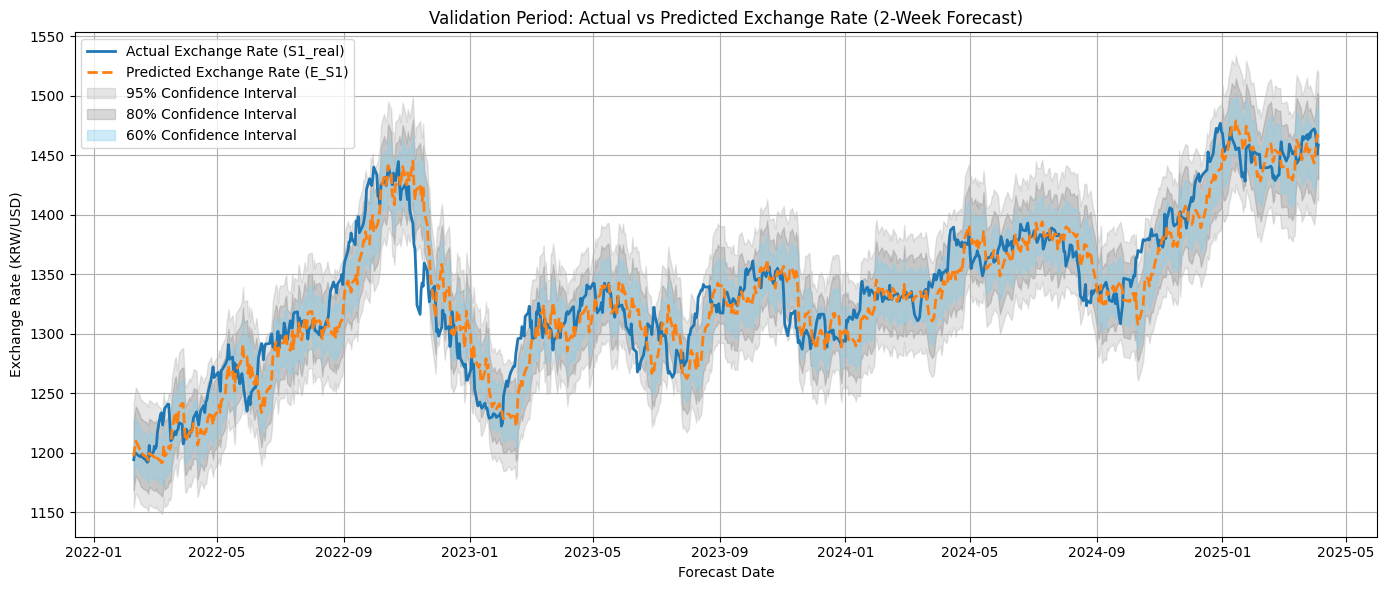

In [ ]:
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay




Z_VALUES = {
    '60': 0.8416,
    '80': 1.2816,
    '95': 1.96
}

# 데이터 8:2로 나누기
cut = int(len(df) * 0.8)
df_parts = {
    '훈련(80%)': df.iloc[:cut].reset_index(drop=True),
    '검증(20%)': df.iloc[cut:].reset_index(drop=True)
}

# 분석 및 시각화 함수
def evaluate_prediction(df_part, label):
    results = []
    for i in range(horizon, len(df_part) - horizon):
        S0 = df_part['spot_rate'].iloc[i]
        S_prev = df_part['spot_rate'].iloc[i - horizon]
        S1 = df_part['spot_rate'].iloc[i + horizon]

        r_int = (df_part['us_rate'].iloc[i] - df_part['kr_rate'].iloc[i]) / 100 * t
        K0 = np.log(S0 / S_prev) - r_int

        log_S0 = np.log(S0)
        E_logS_t = (
            log_S0 + r_int +
            (K0 / theta) * (1 - np.exp(-theta * t))
        )

        Var_logS_t = (sigma_S**2) * t + (sigma_K**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t))
        Std_logS_t = np.sqrt(Var_logS_t)

        row = {
            'Date': df_part['Date'].iloc[i],
            'S0': S0,
            'S1_real': S1,
            'E_S1': np.exp(E_logS_t)
        }

        for level, Z in Z_VALUES.items():
            lower = np.exp(E_logS_t - Z * Std_logS_t)
            upper = np.exp(E_logS_t + Z * Std_logS_t)
            row[f'Lower_{level}'] = lower
            row[f'Upper_{level}'] = upper
            row[f'Covered_{level}'] = lower <= S1 <= upper

        results.append(row)

    result_df = pd.DataFrame(results)
    result_df['Forecast_Date'] = result_df['Date'] + BDay(horizon)

    # 신뢰구간 포함률 출력
    print(f"✅ {label} 신뢰구간별 실제 환율 포함률 (1개월 기준):")
    for level in Z_VALUES:
        hit = result_df[f'Covered_{level}'].mean()
        print(f"  - {level}% 신뢰구간: {hit:.2%}")
    print()

    # 검증 구간일 때만 그래프 그리기
    if "검증" in label:
        plt.figure(figsize=(14, 6))
        plt.plot(result_df['Forecast_Date'], result_df['S1_real'], label='Actual Exchange Rate (S1_real)', linewidth=2)
        plt.plot(result_df['Forecast_Date'], result_df['E_S1'], label='Predicted Exchange Rate (E_S1)', linewidth=2, linestyle='--')

        plt.fill_between(result_df['Forecast_Date'], result_df['Lower_95'], result_df['Upper_95'],
                         color='gray', alpha=0.2, label='95% Confidence Interval')
        plt.fill_between(result_df['Forecast_Date'], result_df['Lower_80'], result_df['Upper_80'],
                         color='gray', alpha=0.3, label='80% Confidence Interval')
        plt.fill_between(result_df['Forecast_Date'], result_df['Lower_60'], result_df['Upper_60'],
                         color='skyblue', alpha=0.4, label='60% Confidence Interval')

        plt.title("Validation Period: Actual vs Predicted Exchange Rate (2-Week Forecast)")
        plt.xlabel("Forecast Date")
        plt.ylabel("Exchange Rate (KRW/USD)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# 훈련(80%) / 검증(20%) 구간 각각 실행
for label, df_part in df_parts.items():
    evaluate_prediction(df_part, label)